## MLPerf HPC v0.7 results visualization

## Choose benchmark

In [ ]:
from collections import namedtuple
MLPerfBenchmark = namedtuple('MLPerfBenchmark',['round','name'])

In [ ]:
# Choose benchmark to visualize

benchmark = MLPerfBenchmark(round='hpc_results_v0.7', name='cosmoflow') 
# benchmark = MLPerfBenchmark(round='hpc_results_v0.7', name='deepcam')

In [ ]:
# paths of results repos
import json
with open('mlperf_results_paths.json', 'r') as results_paths_f:
    mlperf_results_dirs = json.load(results_paths_f)

## Parse results

In [4]:
import glob
import re
import os
import subprocess
import math
import functools
import inspect
import numpy as np
from pprint import pprint
from IPython.display import display

In [5]:
benchmark_results_dir = mlperf_results_dirs[benchmark.round]
mlperf_results_dirs[benchmark.round]

'../hpc_results_v0.7/'

In [6]:
benchmark_submissions = glob.glob( os.path.join(benchmark_results_dir, '*/results/*/' + benchmark.name) )
benchmark_submissions

['../hpc_results_v0.7/Fujitsu/results/abci_2048xV100_tensorflow_open/cosmoflow',
 '../hpc_results_v0.7/Fujitsu/results/fugaku_16384xA64FX_tensorflow_open/cosmoflow',
 '../hpc_results_v0.7/Fujitsu/results/fugaku_8192xA64FX_tensorflow_closed/cosmoflow',
 '../hpc_results_v0.7/Fujitsu/results/abci_512xV100_tensorflow_closed/cosmoflow',
 '../hpc_results_v0.7/RIKEN/results/fugaku_512xA64FX_tensorflow_closed/cosmoflow',
 '../hpc_results_v0.7/CSCS/results/daint_gpu_n256_tf2.2.0/cosmoflow',
 '../hpc_results_v0.7/CSCS/results/daint_gpu_n128_tf2.2.0/cosmoflow',
 '../hpc_results_v0.7/NCSA/results/halv100_n16_tf1.15.0/cosmoflow',
 '../hpc_results_v0.7/LBNL/results/coriknl_n512_tf1.15.2/cosmoflow',
 '../hpc_results_v0.7/LBNL/results/coriknl_n1024_tf1.15.2/cosmoflow',
 '../hpc_results_v0.7/LBNL/results/corigpu_n64_tf1.15.0/cosmoflow',
 '../hpc_results_v0.7/TACC/results/frontera_rtx_n16_tf1.15.2_lbs1/cosmoflow']

In [7]:
# %%bash
# ls $(pwd)/${benchmark_results_dir}/*/systems/

In [8]:
mlperf_opts = {
    'hpc_results_v0.7': {},
}

In [9]:
# MLPerf HPC Cosmoflow hyperparameters
mlperf_opts['hpc_results_v0.7']['cosmoflow'] = {

    # global_batch_size

    # opt_name must be SGD for closed

    'opt_opts_names' : dict(
        SGD=\
        ['sgd_opt_momentum',
         'opt_base_learning_rate',
         'opt_learning_rate_warmup_epochs',
         'opt_learning_rate_warmup_factor',
         'opt_learning_rate_decay_boundary_epochs',
         'opt_learning_rate_decay_factor']
    ),
    'runs_to_submit' : 10,
    'eval_target_key': 'eval_error',
}

In [10]:
# MLPerf HPC DeepCAM hyperparameters

mlperf_opts['hpc_results_v0.7']['deepcam'] = {

    # global_batch_size

    # opt_name must be AdamW or LAMB  for closed

    'opt_opts_names' : dict(
        AdamW=\
        ['opt_epsilon',
         'opt_base_learning_rate',
         'opt_learning_rate_warmup_steps',
         'opt_learning_rate_warmup_factor',
         'opt_learning_rate_decay_steps',
         'opt_learning_rate_decay_factor',
         'opt_weight_decay',
        ],
        LAMB=\
        ['opt_epsilon',
         'opt_base_learning_rate',
         'opt_learning_rate_warmup_steps',
         'opt_learning_rate_warmup_factor',
         'opt_weight_decay',
        ]
#         'validation_frequency', fixed to 100
#         'loss_weight_pow'       fixed to -0.125
    ),
    
    'runs_to_submit' : 5,
    'eval_target_key': 'eval_accuracy',
}

In [11]:
template_pattern = r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'

train_samples_pattern =  re.compile(template_pattern.format('train_samples'), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
eval_samples_pattern  =  re.compile(template_pattern.format('eval_samples'),  re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission

epoch_start_pattern =  re.compile(template_pattern.format('epoch_start'), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
eval_start_pattern  =  re.compile(template_pattern.format('eval_start' ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
eval_stop_pattern   =  re.compile(template_pattern.format('eval_stop'  ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
eval_target_pattern   =  re.compile(template_pattern.format(mlperf_opts[benchmark.round][benchmark.name]['eval_target_key']), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
epoch_stop_pattern  =  re.compile(template_pattern.format('epoch_stop' ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission

if benchmark.round == 'hpc_results_v0.7':
    staging_start_pattern  =  re.compile(template_pattern.format('staging_start' ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
    staging_stop_pattern   =  re.compile(template_pattern.format('staging_stop'  ), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
    

# Optimizer/hyperparameters
global_batch_size_pattern =  re.compile(r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'.format('global_batch_size'), re.M) # [\s\S]*^ at the beginning not possible due to NVIDIA submission
opt_name_pattern =           re.compile(r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'.format('opt_name'), re.M)

opt_patterns = { 
    opt_name:  { k: re.compile(r'[\s\S]*:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]*'.format(k), re.M) 
              for k in mlperf_opts[benchmark.round][benchmark.name]['opt_opts_names'][opt_name] }
    for opt_name in mlperf_opts[benchmark.round][benchmark.name]['opt_opts_names']
}

# Epochs to convergence
run_start_pattern =        re.compile(r'[\s\S]*^:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$'.format('run_start'), re.M)
run_stop_pattern =         re.compile(r'[\s\S]*^:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$'.format('run_stop'), re.M)

last_eval_target_pattern = re.compile(r'[\s\S]*^:::MLLOG([\s\S]+?"key":[\s]*?"{}"[\s\S]+?)$[\s\S]+?"key":[\s]*?"{}"[\s\S]+'.format(mlperf_opts[benchmark.round][benchmark.name]['eval_target_key'], 'run_stop'), re.M)

In [12]:
submissions_stats = dict()
for submission in benchmark_submissions: 

    print(submission, flush=True)
    submitter = submission.split('/')[-4]
    system_name  = submission.split('/')[-2]
    with open(os.path.join('/'.join(submission.split('/')[:-3]), 'systems', system_name + '.json'), 'r') as system_desc_file:
        system_desc = json.load(system_desc_file)
        system_desc['division'] = system_desc['division'].lower()
        if not system_desc['division'] in ['open', 'closed']:
            print(f'Erroneous division {system_desc["division"]} in system description of {submitter}!')
    submission_results = glob.glob(submission + '/result*')
    results = []
    for result in submission_results:
       
        # epoch times
        epoch_start_content = subprocess.run(['/bin/grep', 'epoch_start', result], capture_output=True).stdout.decode('utf-8')
        epoch_starts = [json.loads(epoch_start_pattern.search(l).group(1)) for l in epoch_start_content.split('\n') if len(l) > 0]

        epoch_stop_content = subprocess.run(['/bin/grep', 'epoch_stop', result], capture_output=True).stdout.decode('utf-8')
        epoch_stops = [json.loads(epoch_stop_pattern.search(l).group(1)) for l in epoch_stop_content.split('\n') if len(l) > 0]

        if not( len(epoch_starts) == len(epoch_stops) ):
            print(f"Skipping {result} due to non-closed epoch interval...")
            continue
        for i in range(len(epoch_starts)):
            assert epoch_starts[i]['metadata']['epoch_num'] == epoch_stops[i]['metadata']['epoch_num']

        epochs = list(zip([ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in epoch_starts], [ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in epoch_stops]))

        # eval times
        eval_start_content = subprocess.run(['/bin/grep', 'eval_start', result], capture_output=True).stdout.decode('utf-8')
        eval_starts = [json.loads(eval_start_pattern.search(l).group(1)) for l in eval_start_content.split('\n') if len(l) > 0]

        eval_stop_content = subprocess.run(['/bin/grep', 'eval_stop', result], capture_output=True).stdout.decode('utf-8')
        eval_stops = [json.loads(eval_stop_pattern.search(l).group(1)) for l in eval_stop_content.split('\n') if len(l) > 0]

        eval_target_content = subprocess.run(['/bin/grep', mlperf_opts[benchmark.round][benchmark.name]['eval_target_key'], result], capture_output=True).stdout.decode('utf-8')
        eval_targets = [json.loads(eval_target_pattern.search(l).group(1)) for l in eval_target_content.split('\n') if len(l) > 0]
        
        if not( len(eval_starts) == len(eval_stops) ):
            print(f"Skipping {result} due to non-closed eval interval.")
            continue
        elif not(len(eval_starts) in [0, len(eval_targets)]):
            print(f"Skipping {result} due to more with eval_start/eval_stop intervals ({len(eval_starts)}) than {mlperf_opts[benchmark.round][benchmark.name]['eval_target_key']} ({len(eval_targets)}) entries.")
            continue
        for i in range(len(eval_starts)):
            if 'epoch_num' in eval_starts[i]['metadata']:
                assert eval_starts[i]['metadata']['epoch_num'] == eval_stops[i]['metadata']['epoch_num']

        if len(eval_starts) == 0 and len(eval_stops) == 0:
            print(f"Warning: {result} has no eval_start/eval_stop logs - assuming training took the entire epoch time.")
            
        evals = list(zip([ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in eval_starts], [ts['time_ms']/1000. if 'time_ms' in ts else float(ts['time_s']) for ts in eval_stops]))

        eval_targets = [(ts['value'], int(ts['metadata']['epoch_num'])) for ts in eval_targets]
        
        if len(evals) > 0: # not met by some benchmark.round == 'training_results_v0.7' submissions
            eval_lb, eval_ub = zip(*evals)
            eval_time = np.sum(np.array(eval_ub) - np.array(eval_lb))
        else:
            eval_time = None

        if len(epochs) > 0: # not met by some benchmark.round == 'training_results_v0.7' submissions
            epoch_lb, epoch_ub = zip(*epochs)
            epoch_time = np.sum(np.array(epoch_ub) - np.array(epoch_lb))
        else:
            epoch_time = None

        train_time = epoch_time - eval_time if eval_time is not None else epoch_time

        # staging time
        if benchmark.round == 'hpc_results_v0.7':
            staging_start_content = subprocess.run(['/bin/grep', 'staging_start', result], capture_output=True).stdout.decode('utf-8')
            staging_starts = [json.loads(staging_start_pattern.search(l).group(1)) for l in staging_start_content.split('\n') if len(l) > 0]

            staging_stop_content = subprocess.run(['/bin/grep', 'staging_stop', result], capture_output=True).stdout.decode('utf-8')
            staging_stops = [json.loads(staging_stop_pattern.search(l).group(1)) for l in staging_stop_content.split('\n') if len(l) > 0]
            
            assert len(staging_starts) == len(staging_stops)
            assert len(staging_starts) <= 1
                        
            if len(staging_starts) == 1:
                if system_desc['system_name'] in ['ABCI PRIMERGY CX2570 M4', 
                                                  'fugaku_16384xA64FX_tensorflow_open', 
                                                  'fugaku_8192xA64FX_tensorflow_closed',
                                                  'ABCI PRIMERGY CX2570 M4',
                                                  'fugaku_512xA64FX_tensorflow_closed',
                                                  'corigpu_n64_tf1.15.0']:
                    run_staging_time = staging_stops[0]['time_ms']/1000. - staging_starts[0]['time_ms']/1000.
                else:
#                     system_desc['system_name'] in ['coriknl_n512_tf1.15.2',
#                                                   'coriknl_n1024_tf1.15.2',
#                                                   'daint_gpu_n256_tf2.2.0',
#                                                    'daint_gpu_n128_tf2.2.0',
#                                                    'Frontera-RTX']
                      print(f"Staging: excluding {system_desc['system_name']}.")
                      run_staging_time = None
            else: 
#                 system_desc['system_name'] in ['hal_v100_n16_tf1.15.0',
#                                                'corigpu_n64_pt1.6.0']
                print(f"Staging: No entry in {system_desc['system_name']}.")
                run_staging_time = None
        else:
            run_staging_time = None
            
        
        # Sample numbers
        train_samples_content = subprocess.run(['/bin/grep', 'train_samples', result], capture_output=True).stdout.decode('utf-8')
        train_samples = json.loads(train_samples_pattern.search(train_samples_content).group(1))['value']

        eval_samples_content = subprocess.run(['/bin/grep', 'eval_samples', result], capture_output=True).stdout.decode('utf-8')
        eval_samples = json.loads(eval_samples_pattern.search(eval_samples_content).group(1))['value']        
        
        # Optimizer parameters
        global_batch_size_content = subprocess.run(['/bin/grep', 'global_batch_size', result], capture_output=True).stdout.decode('utf-8')
        global_batch_size = json.loads(global_batch_size_pattern.search(global_batch_size_content).group(1))['value']

        opt_name_content = subprocess.run(['/bin/grep', 'opt_name', result], capture_output=True).stdout.decode('utf-8')
        opt_name = json.loads(opt_name_pattern.search(opt_name_content).group(1))['value']
        
        if benchmark.name == 'cosmoflow':
            if opt_name == 'SGDWD' and submission.endswith('Fujitsu/results/fugaku_8192xA64FX_tensorflow_closed/cosmoflow'):
                opt_name = 'SGD'
        
        opt_opts = {}
        if system_desc['division'] == 'closed':
            for opt_opt, opt_opt_pattern in opt_patterns[opt_name].items():
                if opt_opt == 'sgd_opt_momentum': # no one is using it - forgotten in the reference implementation?
                    continue 
                if benchmark.name == 'deepcam' and opt_opt == 'opt_weight_decay' and 'corigpu_n64_pt1.6.0' in submission:
                    opt_opts[opt_opt] = 0.01
                    continue                 
                opt_opt_content = subprocess.run(['/bin/grep', opt_opt, result], capture_output=True).stdout.decode('utf-8')
                opt_opts[opt_opt] = json.loads(opt_opt_pattern.search(opt_opt_content).group(1))['value']
#         print(global_batch_size_content, flush=True)            


        run_stop_content = subprocess.run(['/bin/grep', '-C', '8', 'run_stop', result], capture_output=True).stdout.decode('utf-8')
#         print(run_stop_content, flush=True)
        
        run_stop_match = run_stop_pattern.search(run_stop_content)
        if run_stop_match is None:
            print(f"Skipping {result} (run_stop not found)", flush=True)
            continue
#         print(json.loads(run_stop_match.group(1)), flush=True)
        run_stop = json.loads(run_stop_match.group(1))
        if 'status' in run_stop['metadata'] and run_stop['metadata']['status'] != 'success':
            print(f"Skipping {result} (run_stop status was {json.loads(run_stop_match.group(1))['metadata']['status']} != success)", flush=True)
            continue
        elif not 'status' in run_stop['metadata']:
            print(f"Warning: {result} has no status field: run_stop['metadata'] = {json.loads(run_stop_match.group(1))['metadata']}", flush=True)
            
#         print(run_stop_content, flush=True)
        run_start_content = subprocess.run(['/bin/grep', 'run_start', result], capture_output=True).stdout.decode('utf-8')
        run_start_match = run_start_pattern.search(run_start_content)
        run_start = json.loads(run_start_match.group(1))
        
        run_time = (run_stop['time_ms']-run_start['time_ms'])/1000. if 'time_ms' in run_stop else run_stop['time_s']-run_start['time_s']

        last_eval_target_match = json.loads(last_eval_target_pattern.search(run_stop_content).group(1))
        run_stop_epoch = last_eval_target_match['metadata']['epoch_num']
        
        if benchmark.round == 'hpc_results_v0.7' and epoch_starts[0]['metadata']['epoch_num'] == 0:
                run_stop_epoch += 1
#         if benchmark.round == 'training_results_v0.7' and block_starts[0]['metadata']['first_epoch_num'] == 0:
#                 run_stop_epoch += 1            

        if benchmark.round == 'hpc_results_v0.7':
            run_num_epochs = len(epochs)
            run_num_evals = len(evals)
#         elif benchmark.round == 'training_results_v0.7':
#             run_num_epochs = np.sum([b[1] for b in blocks['epoch_intervals']])
#             if block_starts[0]['metadata']['first_epoch_num'] == 0:
#                 run_num_epochs += 1 
#             run_num_evals = len(evals) if len(evals) > 0 else len(eval_targets)
        
        if run_stop_epoch != run_num_epochs: # epoch counting must start from 0 or 1
            if len(epoch_starts) > 0:
                raise RuntimeError(f"Not expected to run {run_num_epochs-run_stop_epoch} extra epoch(s) after reaching target.")
            else:
                print(f"Warning: Ran {run_num_epochs - run_stop_epoch} extra epoch(s) in final block after reaching target.")
        
        results.append( dict(
            global_batch_size=global_batch_size, 
            opt_name=opt_name,
            opt_opts=opt_opts,
            run_stop_epoch=run_stop_epoch,
            run_time=run_time,
            run_epoch_throughput=run_stop_epoch/epoch_time,
            run_epoch_time=epoch_time/run_stop_epoch,
            train_samples=train_samples,
            eval_samples=eval_samples,
            run_train_time=train_time,
            run_eval_time=eval_time,
            run_avg_epoch_samples=int(train_samples + (run_num_evals/float(run_num_epochs))*eval_samples),
#             run_num_epochs=run_num_epochs, #(same as run_stop_epochs)
            run_num_evals=run_num_evals,            
            run_train_throughput=run_num_epochs*float(train_samples)/train_time,
            run_eval_throughput=run_num_evals*float(eval_samples)/eval_time if eval_time is not None else None,
            run_avg_epoch_sample_throughput=run_stop_epoch/epoch_time*int(train_samples + (run_num_evals/float(run_num_epochs))*eval_samples),
            run_staging_time=run_staging_time,
            run_staging_throughput=float(train_samples + eval_samples)/run_staging_time if run_staging_time is not None else None,
#             run_epochs=epochs,
#             run_evals=evals,
            division=system_desc['division'],
            system=system_desc,
        ) )
    
    # Reduce shared features across runs
    submission_stats_results = dict()
    for k in results[0].keys():
        if not k.startswith('run'):
            for r in results[1:]:
                assert results[0][k] == r[k]
            submission_stats_results[k] = results[0][k]
    
    # run-specific features as a sequence
    submission_stats_results['runs'] = []
    for r in results:
        submission_stats_results['runs'].append({ k: r[k] for k in results[0].keys() if k.startswith('run')})
    submissions_stats[submission] = submission_stats_results
    
# if benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow': # review issue
#     for k in submissions_stats.keys():
#         if 'fugaku_512xA64FX_tensorflow_closed' in k:
#             reference_epochs = np.mean(sorted(np.array([94, 113, 100, 113, 127, 100, 106, 134, 91, 150]))[1:-1])
#             epochs_correction_factor = reference_epochs/np.mean([run['run_stop_epoch'] for run in submissions_stats[k]['runs']])
#             for i,_ in enumerate(submissions_stats[k]['runs']):
#                 submissions_stats[k]['runs'][i]['run_time'] = submissions_stats[k]['runs'][i]['run_staging_time'] + \
#                                                              (submissions_stats[k]['runs'][i]['run_time'] - submissions_stats[k]['runs'][i]['run_staging_time'])*epochs_correction_factor
#                 submissions_stats[k]['runs'][i]['run_stop_epoch'] = submissions_stats[k]['runs'][i]['run_stop_epoch']*epochs_correction_factor

def accelerator_number(system):
    number_of_nodes = int(system['number_of_nodes'])
    accelerators_per_node = int(system['accelerators_per_node'] if int(system['accelerators_per_node']) > 0 else system['host_processors_per_node'])
    return number_of_nodes*accelerators_per_node

submissions_ids = {k.split('/')[-4]: 0 for k in submissions_stats.keys()}

for k in submissions_stats.keys():
    submitter = k.split('/')[-4]
    system = k.split('/')[-2]
    submissions_ids[submitter] += 1
    submissions_stats[k]['submission_label'] =       submitter + f'-{submissions_ids[submitter]}/' + system
    if benchmark.round != 'hpc_results_v0.7':
        submissions_stats[k]['submission_short_label'] = submitter + f'-{submissions_ids[submitter]}'
    else:
        hpc_v07_systems = {'ABCI':         ['ABCI',         'ABCI',             ], 
                           'fugaku':       ['Fugaku',       'Fugaku\n',         ], 
                           'corigpu':      ['Cori-GPU',     'Cori-GPU\n',       ], 
                           'coriknl':      ['Cori-KNL',     'Cori-KNL\n',       ], 
                           'daint':        ['Piz-Daint',    'Piz-Daint\n',      ], 
                           'hal':          ['HAL',          'HAL',              ], 
                           'Frontera-RTX': ['Frontera\n-RTX', 'Frontera\n-RTX' ]}
        for system_name in hpc_v07_systems:
            if system_name in submissions_stats[k]['system']['system_name']:
                submissions_stats[k]['submission_short_label'] = f'{hpc_v07_systems[system_name][1]}-{accelerator_number(submissions_stats[k]["system"])}'
                submissions_stats[k]['submission_long_label' ] = f'{hpc_v07_systems[system_name][0]}-{accelerator_number(submissions_stats[k]["system"])}'
                epochs_system_label = hpc_v07_systems[system_name][0]
                if submissions_stats[k]['division'] == 'open':
                    epochs_system_label += '\n'
                elif system_name == 'corigpu':
                    epochs_system_label = epochs_system_label.replace('-','\n-')
#                 epochs_system_label = hpc_v07_systems[system_name][0] + ('' if system_name != 'corigpu' and submissions_stats[k]['division'] != 'open' else "\n") 
                submissions_stats[k]['submission_epochs_label' ] = f'{epochs_system_label}-{accelerator_number(submissions_stats[k]["system"])}'

print('...done!')

../hpc_results_v0.7/Fujitsu/results/abci_2048xV100_tensorflow_open/cosmoflow
../hpc_results_v0.7/Fujitsu/results/fugaku_16384xA64FX_tensorflow_open/cosmoflow
../hpc_results_v0.7/Fujitsu/results/fugaku_8192xA64FX_tensorflow_closed/cosmoflow
../hpc_results_v0.7/Fujitsu/results/abci_512xV100_tensorflow_closed/cosmoflow
../hpc_results_v0.7/RIKEN/results/fugaku_512xA64FX_tensorflow_closed/cosmoflow
../hpc_results_v0.7/CSCS/results/daint_gpu_n256_tf2.2.0/cosmoflow
Staging: excluding daint_gpu_n256_tf2.2.0.
Staging: excluding daint_gpu_n256_tf2.2.0.
Staging: excluding daint_gpu_n256_tf2.2.0.
Staging: excluding daint_gpu_n256_tf2.2.0.
Staging: excluding daint_gpu_n256_tf2.2.0.
Staging: excluding daint_gpu_n256_tf2.2.0.
Staging: excluding daint_gpu_n256_tf2.2.0.
Staging: excluding daint_gpu_n256_tf2.2.0.
Skipping ../hpc_results_v0.7/CSCS/results/daint_gpu_n256_tf2.2.0/cosmoflow/result_4.txt due to non-closed epoch interval...
Staging: excluding daint_gpu_n256_tf2.2.0.
../hpc_results_v0.7/CSCS/r

In [13]:
%%bash
# tail -n 100 ../hpc_results_v0.7/TACC/results/frontera_rtx_n16_tf1.15.2_lbs1/cosmoflow/result_3.txt
# ls -l ../hpc_results_v0.7/TACC/results/frontera_rtx_n16_tf1.15.2_lbs1/cosmoflow/
# head -n 30 '../hpc_results_v0.7/Fujitsu/results/fugaku_16384xA64FX_tensorflow_open/cosmoflow/result_6.txt'

In [14]:
[s['submission_epochs_label'] for s in submissions_stats.values()]

['ABCI\n-2048',
 'Fugaku\n-16384',
 'Fugaku-8192',
 'ABCI-512',
 'Fugaku-512',
 'Piz-Daint-256',
 'Piz-Daint-128',
 'HAL-64',
 'Cori-KNL-512',
 'Cori-KNL\n-1024',
 'Cori\n-GPU-64',
 'Frontera\n-RTX-64']

In [15]:
# For illustration
example_submission = list(submissions_stats.keys())[0]
print(example_submission)
submissions_stats[example_submission]

../hpc_results_v0.7/Fujitsu/results/abci_2048xV100_tensorflow_open/cosmoflow


{'global_batch_size': 2048,
 'opt_name': 'SGD',
 'opt_opts': {},
 'train_samples': 262144,
 'eval_samples': 65536,
 'division': 'open',
 'system': {'submitter': 'Fujitsu',
  'division': 'open',
  'system_type': 'datacenter',
  'status': 'available',
  'system_name': 'ABCI PRIMERGY CX2570 M4',
  'number_of_nodes': '512',
  'host_processors_per_node': '2',
  'host_processor_model_name': 'Intel Xeon Gold 6148',
  'host_processor_core_count': '40',
  'host_processor_vcpu_count': '80',
  'host_processor_frequency': '2400MHz',
  'host_processor_caches': 'L1: 32KB I + 32KB D per core, L2: 1MB I+D per core, L3: 27.5MB I+D per chip',
  'host_processor_interconnect': '3x 10.4GT/s UPI',
  'host_memory_capacity': '384GB',
  'host_storage_type': 'SSD+NVMe',
  'host_storage_capacity': '1600GB',
  'host_networking': 'N/A',
  'host_networking_topology': 'N/A',
  'host_memory_configuration': '12x32GB',
  'accelerators_per_node': '4',
  'accelerator_model_name': 'NVIDIA Tesla V100',
  'accelerator_host_

## Visualize results

In [16]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [17]:
%matplotlib inline

In [18]:
plt.rcParams.update({'font.size': 14})

### Plotting functions

In [19]:
# kernel density estimator for plot

from sklearn.neighbors import KernelDensity
from scipy.stats import norm


def kde_estimate(run_stop_epochs):
    # instantiate and fit the KDE model    
    kde = KernelDensity(bandwidth=0.5*np.std(run_stop_epochs), kernel='gaussian')
    kde.fit(run_stop_epochs[:,None])

    # score_samples returns the log of the probability density
    epochs = np.linspace(np.min(run_stop_epochs)-2.5*np.std(run_stop_epochs), np.max(run_stop_epochs)+2.5*np.std(run_stop_epochs), 100)
    return epochs, np.exp(kde.score_samples(epochs[:,None]))
#     mean, std = norm.fit(run_stop_epochs)
#     return epochs, norm.pdf(epochs, mean, std)

In [20]:
# Create level lines in loglog-plots

def level_log(value, base):
    if base == 10:
        return np.log10(value)
    elif base == 2:
        return np.log2(value)
    else:
        return np.log(value)/np.log(base)

def plot_level_lines(ax, x_range, y_range, level_func, level_label, level_transform=None, level_log_base=10., level_color='black', level_fine_grid=1):
    assert level_func in ['x*y', 'y*x', 'x/y', 'y/x']
    
    # Slopes of lines through corners of plotted window
    if level_func in ['x/y', 'y/x']:
        min_level =       y_range[0]/x_range[1]
        lhs_split_level = y_range[0]/x_range[0]
        rhs_split_level = y_range[1]/x_range[1]
        max_level =       y_range[1]/x_range[0]
    else: # level_func in ['x*y', 'y*x']
        min_level =       y_range[0]*x_range[0]
        lhs_split_level = y_range[1]*x_range[0]
        rhs_split_level = y_range[0]*x_range[1]
        max_level =       y_range[1]*x_range[1]

    disp_min_level = min_level if level_func != 'x/y' else 1./max_level 
    disp_max_level = max_level if level_func != 'x/y' else 1./min_level
    if level_transform is not None:
        disp_min_level = level_transform[0](disp_min_level)
        disp_max_level = level_transform[0](disp_max_level)
        
    log_min_level_ceiled  = np.ceil(level_log(disp_min_level, level_log_base))
    log_max_level_floored = np.floor(level_log(disp_max_level, level_log_base))
      
    coarse_disp_levels = np.logspace(log_min_level_ceiled, log_max_level_floored, int(log_max_level_floored-log_min_level_ceiled)+1, base=level_log_base)
    for disp_level in coarse_disp_levels: #[1:-1]:
        level = level_transform[1](disp_level) if level_transform is not None else disp_level
        level = level if level_func != 'x/y' else 1./level
        if level_func in ['x/y', 'y/x']:
            if level > lhs_split_level:
                lhs = np.array((x_range[0], x_range[0]*level))/2.**0.5
            else:
                lhs = np.array((y_range[0]/level, y_range[0]))/2.**0.5
            if level > rhs_split_level:
                rhs = np.array((y_range[1]/level, y_range[1]))*2.**0.5
                level_annotate_opts = dict(xytext=(0,5), ha='center', va='bottom') 
            else:
                rhs = np.array((x_range[1], x_range[1]*level))*2.**0.5
                level_annotate_opts = dict(xytext=(0,5), ha='center', va='bottom') 
        else: # level_func in ['x*y', 'y*x']
            if level < lhs_split_level:
                lhs = np.array((      x_range[0]/2.**0.5, level/x_range[0]*2.**0.5))
            else:
                lhs = np.array((level/y_range[1]/2.**0.5,       y_range[1]*2.**0.5))
            if level < rhs_split_level:
                rhs = np.array((level/y_range[0]*2.**0.5,       y_range[0]/2.**0.5))
                level_annotate_opts = dict(xytext=(0,-5), ha='center', va='top') 
            else:
                rhs = np.array((      x_range[1]*2.**0.5, level/x_range[1]/2.**0.5))
                level_annotate_opts = dict(xytext=(0,-5), ha='center', va='top') 
#         from IPython.core.debugger import set_trace
#         set_trace()
        ax.plot([lhs[0], rhs[0]], [lhs[1], rhs[1]], ':', color=level_color, alpha=0.3, zorder=0)
#         disp_level = level if level_func != 'x/y' else 1./level
#         if level_transform is not None:
#             disp_level = level_transform[0](disp_level)
        ax.annotate(r"${log_base}^{{{log_level:d}}}$".format(log_base=int(level_log_base) if level_log_base == int(level_log_base) else level_log_base, log_level=int(level_log(disp_level,level_log_base))), 
                    xy=rhs,
                    **level_annotate_opts,
                    textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                    color=level_color,
                    alpha=0.5)
    if level_fine_grid > 1:
        assert int(level_log_base) == level_log_base
        for lower_coarse_disp_level, upper_coarse_disp_level in zip(coarse_disp_levels[:-1],coarse_disp_levels[1:]):
#             for disp_level in np.linspace(lower_coarse_disp_level, upper_coarse_disp_level, level_fine_grid+1)[1:-1]:
            for disp_level in np.logspace(int(level_log(lower_coarse_disp_level, level_log_base)), int(level_log(upper_coarse_disp_level, level_log_base)), level_fine_grid+1, base=level_log_base)[1:-1]:
                level = level_transform[1](disp_level) if level_transform is not None else disp_level
                level = level if level_func != 'x/y' else 1./level
                if level_func in ['x/y', 'y/x']:
                    if level > lhs_split_level:
                        lhs = np.array((x_range[0], x_range[0]*level))/2.**0.5
                    else:
                        lhs = np.array((y_range[0]/level, y_range[0]))/2.**0.5
                    if level > rhs_split_level:
                        rhs = np.array((y_range[1]/level, y_range[1]))*2.**0.5
                    else:
                        rhs = np.array((x_range[1], x_range[1]*level))*2.**0.5
                else: # level_func in ['x*y', 'y*x']
                    if level < lhs_split_level:
                        lhs = np.array((      x_range[0]/2.**0.5, level/x_range[0]*2.**0.5))
                    else:
                        lhs = np.array((level/y_range[1]/2.**0.5,       y_range[1]*2.**0.5))
                    if level < rhs_split_level:
                        rhs = np.array((level/y_range[0]*2.**0.5,       y_range[0]/2.**0.5))
                    else:
                        rhs = np.array((      x_range[1]*2.**0.5, level/x_range[1]/2.**0.5))
                ax.plot([lhs[0], rhs[0]], [lhs[1], rhs[1]], ':', color=level_color, alpha=0.3, zorder=0)
            

    ax.annotate(level_label[0],
                xy=(x_range[0],y_range[1] if level_func in ['x/y', 'y/x'] else y_range[0]),
                xytext=(15,5),
                textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                ha='center', va='bottom',
                fontsize='small',
                color=level_color,
                alpha=0.5)        
    ax.annotate(level_label[1],
                xy=(x_range[0],y_range[1] if level_func in ['x/y', 'y/x'] else y_range[0]),
                xytext=(15,-5),
                textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                ha='center', va='top',
                fontsize='small',
                color=level_color,
                alpha=0.5)    



In [21]:
def create_submission_colors(color_label=None, color_label_range=None, filter_submissions=None, colormap='gist_rainbow'):
    cmap = plt.cm.get_cmap(colormap)
    colors = cmap(np.arange(0,cmap.N))
    if color_label is None:
        colors = colors[::len(colors)//len(submissions_stats),:]*0.65
        colors = dict(zip(list(submissions_stats.keys()), colors))
    else:
        if color_label_range is None:
            color_label_range = np.unique([color_label(submission_stat) for submission_stat in submissions_stats.values() if filter_submissions(submission_stat)])
            print(color_label_range)
        colors = colors[::len(colors)//len(color_label_range),:]*0.65
#         np.random.shuffle(colors)
        colors = dict(zip(color_label_range, colors))
    return colors


#Testing
def show_submission_colors(color_label, color_label_range=None, filter_submissions=lambda s: True, colormap='gist_rainbow', alpha=1.):
    colors = create_submission_colors(color_label=color_label, color_label_range=color_label_range, filter_submissions=lambda s: True, colormap=colormap)
    plt.barh([i for i,_ in enumerate(colors)], [1]*len(colors), color=list(colors.values()), tick_label=list(colors.keys()), alpha=alpha)

In [22]:
# TODO: Make filtering interactive with widgets

def plot_all_submissions(x_key, y_key, x_label=None, y_label=None, y_transform=None, y_legend_label=None, secondary_x_key=None, secondary_x_label=None, secondary_x_legend_label=None, secondary_x_marker=None, secondary_x_ticks_same_as_primary=False, primary_to_secondary_x_transform=None, secondary_to_primary_x_transform=None,
                         secondary_y_keys=None, secondary_y_axis_label=None, secondary_y_legend_labels=None, secondary_y_transforms=None, secondary_y_markers=None, primary_to_secondary_y_transform=None, secondary_to_primary_y_transform=None,
                         title=None, sharey=False, axis_scale='semilogx', filter_submissions=lambda s: True, color_label=None, color_label_range=None, legend_side='right', show_symbolic_legend=False, ax=None,
                         level_func=None, level_label=None, level_transform=None, level_color='black', level_log_base=10., level_fine_grid=1, revert_x_axis=False, revert_y_axis=False,
                         format_y_axis_as_x_axis=False, submission_annotation_key='submission_short_label', submission_label_annotation_opts=None, color_legend_label=None):
    
    if type(x_key) is str:
        assert not x_key.startswith('run_')
    if type(secondary_x_key) is str:
        assert not secondary_x_key.startswith('run_')
    if type(y_key) is str:
        assert y_key.startswith('run_')
    if secondary_y_keys is not None:
        for secondary_y_key in secondary_y_keys:
            if type(secondary_y_key) is str:
                assert secondary_y_key.startswith('run_')

    #fig, (ax_clsd, ax_open) = plt.subplots(ncols=2, sharey=sharey, #sharex=True, 
                                   #figsize=(36, 12))

    fig = None
    if ax is None:
        fig, ax = plt.subplots(ncols=1, sharey=sharey, #sharex=True, 
                                figsize=(24, 12))
    ax_clsd = ax
    ax_open = ax
    
    colors = create_submission_colors(color_label=color_label, color_label_range=color_label_range, filter_submissions=filter_submissions)

    if secondary_x_key is not None:
        assert (primary_to_secondary_x_transform is not None) == (secondary_to_primary_x_transform is not None)
        secondary_x_axis_functions = (primary_to_secondary_x_transform, secondary_to_primary_x_transform) if (primary_to_secondary_x_transform is not None) and (secondary_to_primary_x_transform is not None) else None
        secondary_x_ax_clsd = ax_clsd.secondary_xaxis('top', functions=secondary_x_axis_functions) # FIXME: primary x to secondary x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            secondary_x_ax_open = ax_open.secondary_xaxis('top', functions=secondary_x_axis_functions)
        else:
            secondary_x_ax_open = secondary_x_ax_clsd

    if secondary_y_keys is not None:        
        assert (primary_to_secondary_y_transform is not None) == (secondary_to_primary_y_transform is not None)
        secondary_y_axis_functions = (primary_to_secondary_y_transform, secondary_to_primary_y_transform) if (primary_to_secondary_y_transform is not None) and (secondary_to_primary_y_transform is not None) else None
        secondary_y_ax_clsd = ax_clsd.secondary_yaxis('left', functions=secondary_y_axis_functions) # primary x to secondary x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            secondary_y_ax_open = ax_open.secondary_yaxis('left', functions=secondary_y_axis_functions)
        else:
            secondary_y_ax_open = secondary_y_ax_clsd

    
    x_values_min = dict(closed=float('inf'), open=float('inf')) 
    x_values_max = dict(closed=float('-inf'), open=float('-inf'))
    y_values_min = dict(closed=float('inf'), open=float('inf')) 
    y_values_max = dict(closed=float('-inf'), open=float('-inf'))
    
    # Plot all submissions
    for i, (k, submission_stat) in enumerate(submissions_stats.items()):
        
        if not filter_submissions(submission_stat):
            continue
            
        submission_annotation = submission_stat[submission_annotation_key] if type(submission_annotation_key) is str else submission_annotation_key(submission_stat)
        if submission_label_annotation_opts is None:
            submission_annotation_opts = dict(
                        xytext=(-10, 0),
                        textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                        ha='right', va='center',  # rotation=90,
                        alpha=1., fontsize=12)
        else:
            submission_annotation_opts = submission_label_annotation_opts if type(submission_label_annotation_opts) is dict else submission_label_annotation_opts(submission_stat)
        color = colors[k if color_label is None else color_label(submission_stat)]
            
        x_values = submission_stat[x_key] if type(x_key) is str else x_key(submission_stat)
        x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(x_values))
        x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(x_values))
        if secondary_x_key is not None:
            secondary_x_values = submission_stat[secondary_x_key] if type(secondary_x_key) is str else secondary_x_key(submission_stat)
            secondary_x_values = secondary_to_primary_x_transform(secondary_x_values)
            x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(secondary_x_values))
            x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(secondary_x_values))

        submission_stat_runs = sorted(submission_stat['runs'], key=lambda run: run['run_time'])
        submission_stat_runs = submission_stat_runs[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules

        y_values = np.array([run[y_key] if type(y_key) is str else y_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])
        if secondary_y_keys is not None:
            secondary_y_keys_not_none = []
            secondary_y_values = []
            for secondary_y_key in secondary_y_keys:
                secondary_y_values.append( np.array([run[secondary_y_key] if type(secondary_y_key) is str else secondary_y_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs]) )
                secondary_y_keys_not_none.append(None not in secondary_y_values[-1])
                if secondary_y_keys_not_none[-1]:
                    secondary_y_values[-1] = np.array([secondary_to_primary_y_transform(val) for val in secondary_y_values[-1]])

        if y_transform is not None:
            y_values = np.array([y_transform(val) for val in y_values])
        y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(y_values))
        y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(y_values))
#         print(y_values, flush=True)

        if secondary_y_keys is not None:
            for i in np.nonzero(secondary_y_keys_not_none)[0]:  # for i,_ in enumerate(secondary_y_keys):
                if secondary_y_transforms[i] is not None:
                    secondary_y_values[i] = np.array([secondary_y_transforms[i](val) for val in secondary_y_values[i]])
                y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(secondary_y_values[i]))
                y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(secondary_y_values[i]))


        if submission_stat['division'] == 'closed':                
            y_values_unique = np.unique(y_values)
            y_values_frequency = np.array([np.sum(e == np.array(y_values)) for e in y_values_unique])
            ax_clsd.scatter([x_values]*len(y_values_unique),
                        y_values_unique,
                        s=5*y_values_frequency,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_clsd.annotate(submission_annotation,
                        xy=(x_values, np.mean(y_values)),
                        color=color,
                        **submission_annotation_opts)
            if secondary_x_key is not None:
                ax_clsd.plot([secondary_x_values, x_values], # requires secondary_x to primary x scale conversion if non-identity
                         [np.mean(y_values)]*2,
                         '--',
                         color=color,
                         alpha=0.5)
                ax_clsd.scatter([secondary_x_values], # requires secondary_x to primary x scale conversion if non-identity
                         [np.mean(y_values)],
                         s=25,
                         color=color,
                         alpha=1.,
                         marker=secondary_x_marker, 
                         facecolors='white')
            if secondary_y_keys is not None:
                for i in np.nonzero(secondary_y_keys_not_none)[0]: #for i,_ in enumerate(secondary_y_keys):
                    x_factor = 2**(0.05*(i+1) if benchmark.name != 'cosmoflow' else 0.1)
#                     ax_clsd.scatter(secondary_y_values[i],
#                                 [y_values/x_factor]*len(secondary_y_values[i]),
#                                 s=10,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_y_markers[i].lower())                    
#                     ax_clsd.scatter([np.mean(secondary_y_values[i])],
#                                 [y_values/x_factor],
#                                 s=20,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_y_markers[i])
                    ax_clsd.errorbar([x_values/x_factor],
                                     [np.mean(secondary_y_values[i])],
                                yerr=[np.std(secondary_y_values[i])],
                                fmt=secondary_y_markers[i], #markersize=3,
                                color=color,
                                alpha=1.)
                    circle_y, circle_x = horizontal_circle_segment_loglog([np.mean(y_values), np.mean(secondary_y_values[i])], x_values, y_factor=x_factor)
                    ax_clsd.plot(circle_x,
                             circle_y,
                             color=color,
                             alpha=.3)
            if len(y_values_unique) != 1:
                epochs, probs = kde_estimate(y_values)
                ax_clsd.plot(   float(x_values)*2**(np.std(y_values)*probs),
                            epochs,
                            color=color,
                            alpha=0.5)
                ax_clsd.fill_betweenx(
                            epochs,
                            [float(x_values)]*len(probs),
                            float(x_values)*2**(np.std(y_values)*probs),
                            color=color,
                            alpha=0.1)
        elif submission_stat['division'] == 'open':
            y_values_unique = np.unique(y_values)
            y_values_frequency = np.array([np.sum(e == np.array(y_values)) for e in y_values_unique])
            ax_open.scatter([x_values]*len(y_values_unique),
                        y_values_unique,
                        s=5*y_values_frequency,
                        color=color,
                        label=r'$\bigstar$' + submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_open.annotate(r'$\bigstar$' + submission_annotation,
                        xy=(x_values, np.mean(y_values)),
                        color=color,
                        **submission_annotation_opts)
            if secondary_x_key is not None:
                ax_open.plot([secondary_x_values, x_values], # requires secondary_x to primary x scale conversion if non-identity
                         [np.mean(y_values)]*2,
                         '--',
                         color=color,
                         alpha=0.5)
                ax_open.scatter([secondary_x_values], # requires secondary_x to primary x scale conversion if non-identity
                         [np.mean(y_values)],
                         s=25,
                         color=color,
                         alpha=1.,
                         marker=secondary_x_marker, 
                         facecolors='white')
            if secondary_y_keys is not None:
                for i in np.nonzero(secondary_y_keys_not_none)[0]: #for i,_ in enumerate(secondary_y_keys):
                    x_factor = 2**(0.05*(i+1) if benchmark.name != 'cosmoflow' else 0.1)
#                     ax_clsd.scatter(secondary_y_values[i],
#                                 [y_values/x_factor]*len(secondary_y_values[i]),
#                                 s=10,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_y_markers[i].lower())                    
#                     ax_clsd.scatter([np.mean(secondary_y_values[i])],
#                                 [y_values/x_factor],
#                                 s=20,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_y_markers[i])
                    ax_clsd.errorbar([x_values/x_factor],
                                     [np.mean(secondary_y_values[i])],
                                yerr=[np.std(secondary_y_values[i])],
                                fmt=secondary_y_markers[i], #markersize=3,
                                color=color,
                                alpha=1.)
                    circle_y, circle_x = horizontal_circle_segment_loglog([np.mean(y_values), np.mean(secondary_y_values[i])], x_values, y_factor=x_factor)
                    ax_clsd.plot(circle_x,
                             circle_y,
                             color=color,
                             alpha=.3)
            if len(y_values_unique) != 1:
                epochs, probs = kde_estimate(y_values)
                ax_open.plot(   float(x_values)*2**(np.std(y_values)*probs),
                            epochs,
                            color=color,
                            alpha=0.5)
                ax_open.fill_betweenx(
                            epochs,
                            [float(x_values)]*len(probs),
                            float(x_values)*2**(np.std(y_values)*probs),
                            color=color,
                            alpha=0.1)
        else:
            raise ValueError(f"Invalid division {submission_stat['division']}.")

    if legend_side is not None:
        ax_clsd.legend(bbox_to_anchor=( 1.1 if ax_open == ax_clsd and legend_side == 'right' else -0.8, 1), loc='upper left', frameon=False, fontsize='small')
        if ax_open != ax_clsd:
            ax_open.legend(bbox_to_anchor=(1.55, 1), loc='upper right', frameon=False, fontsize='small')

    if show_symbolic_legend:

        symbolic_legend_labels = []
        ax_clsd_twin = ax_clsd.twinx()
        
        # Symbolic legend
        ax_clsd_twin.scatter([], [], label="Symbolic legend", marker="None") 
        symbolic_legend_labels.append("Symbolic legend")
        ax_clsd_twin.scatter([], [], label=y_legend_label, color='black')
        symbolic_legend_labels.append(y_legend_label)
        if secondary_x_key is not None:
            ax_clsd_twin.plot([], [], secondary_x_marker, fillstyle='none', label=secondary_x_legend_label, color='black')
            symbolic_legend_labels.append(secondary_x_legend_label)
        if secondary_y_keys is not None:
            for i,_ in enumerate(secondary_y_keys):
                ax_clsd_twin.plot([], [], secondary_y_markers[i], label=secondary_y_legend_labels[i], color='black')
                symbolic_legend_labels.append(secondary_y_legend_labels[i])

        # Color-coding
        ax_clsd_twin.scatter([], [], label=" ", marker="None") 
        symbolic_legend_labels.append(" ")
        ax_clsd_twin.scatter([], [], label="Color-coding", marker="None") 
        symbolic_legend_labels.append("Color-coding")
        for color_key, color in colors.items():
            ax_clsd_twin.scatter([], [], label=color_legend_label[color_key] if color_legend_label is not None else color_key, color=color, marker='o')
            symbolic_legend_labels.append(color_legend_label[color_key] if color_legend_label is not None else color_key)
        
        ax_clsd_twin.get_yaxis().set_visible(False)

        legend_handles, legend_labels = ax_clsd_twin.get_legend_handles_labels()
        legend_labels, legend_handles = zip(*sorted(zip(legend_labels, legend_handles), key=lambda t: symbolic_legend_labels.index(t[0])))
#         ax_clsd_twin.legend(legend_handles, legend_labels, bbox_to_anchor=(-.65, 0), loc='lower left', frameon=False, fontsize='small')
        ax_clsd_twin.legend(legend_handles, legend_labels, bbox_to_anchor=( 1.6 if legend_side == 'right' else -0.15, 0), loc='lower right', frameon=False, fontsize='small')

    
    ax_clsd.grid(True, which='major', alpha=0.3)
    ax_open.grid(True, which='major', alpha=0.3)

    if axis_scale == 'linear':
        ax_clsd.plot()
        ax_open.plot()
    elif axis_scale == 'semilogx':
        ax_clsd.semilogx()
        ax_open.semilogx()
    elif axis_scale == 'loglog':
        ax_clsd.loglog()
        ax_open.loglog()
    else:
        raise ValueError(f'axis_scale should be in [semilogx, loglog, plot], not {axis_scale}')

    #x_range = dict()

    #for division in ['closed', 'open']:
        #x_range[division] = [submission_stat[x_key] if type(x_key) is str else x_key(submission_stat) for submission_stat in submissions_stats.values() if submission_stat['division'] == division and filter_submissions(submission_stat)]
        #if secondary_x_key is not None:
            #x_range[division] += [submission_stat[secondary_x_key] if type(secondary_x_key) is str else secondary_x_key(submission_stat) for submission_stat in submissions_stats.values() if submission_stat['division'] == division and filter_submissions(submission_stat)]

    #if len(x_range['closed']) > 0:
        #ax_clsd.set_xlim(left=np.min(x_range['closed'])//2 if axis_scale != 'linear' else 0., right=np.max(x_range['closed'])*2)
    #if len(x_range['open']) > 0:
        #ax_open.set_xlim(left=np.min(x_range['open'])//2 if axis_scale != 'linear' else 0.,   right=np.max(x_range['open'])*2)

    if ax_clsd != ax_open:
        if math.isfinite(x_values_min['closed']) and math.isfinite(x_values_max['closed']):
            ax_clsd.set_xlim(left=x_values_min['closed']//2 if axis_scale != 'linear' else 0., right=x_values_max['closed']*2)
        if math.isfinite(x_values_min['open']) and math.isfinite(x_values_max['open']):
            ax_open.set_xlim(left=x_values_min['open']//2 if axis_scale != 'linear' else 0.,   right=x_values_max['open']*2)
    else:
        if math.isfinite(x_values_min['closed']) and math.isfinite(x_values_max['closed']):
            ax_clsd.set_xlim(left=min(x_values_min['closed'], x_values_min['open'])//2 if axis_scale != 'linear' else 0., right=max(x_values_max['closed'], x_values_max['open'])*2)
            
    if revert_x_axis:
        xlim = ax_clsd.get_xlim()
        ax_clsd.set_xlim(xlim[1], xlim[0])

    if revert_y_axis:
        ylim = ax_clsd.get_ylim()
        ax_clsd.set_ylim(ylim[1], ylim[0])

    ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
    ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

    #     plt.FuncFormatter(lambda t: "{}".format(t))
    ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())

    if format_y_axis_as_x_axis:
        ax_clsd.yaxis.set_major_locator(plt.LogLocator(base=2.))
        ax_open.yaxis.set_major_locator(plt.LogLocator(base=2.))

        #     plt.FuncFormatter(lambda t: "{}".format(t))
        ax_clsd.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        ax_open.yaxis.set_major_formatter(plt.ScalarFormatter())

    if secondary_y_keys is not None:
#         secondary_y_ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
#         secondary_y_ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

#         #     plt.FuncFormatter(lambda t: "{}".format(t))
#         secondary_y_ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
#         secondary_y_ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())
        secondary_y_ax_clsd.set_ylabel(secondary_y_axis_label if secondary_y_axis_label is not None else secondary_y_keys[0])
        secondary_y_ax_open.set_ylabel(secondary_y_axis_label if secondary_y_axis_label is not None else secondary_y_keys[0])

    
    if secondary_x_key is not None: # does the following have an effect at all?        
        if secondary_x_ticks_same_as_primary:
            secondary_x_ax_clsd.tick_params(axis='x', top=False, labeltop=False)
            secondary_x_ax_open.tick_params(axis='x', top=False, labeltop=False)
            ax_clsd.tick_params(axis='x', top=True, labeltop=True)
            ax_open.tick_params(axis='x', top=True, labeltop=True)
        else:
            secondary_x_ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
            secondary_x_ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

            #     plt.FuncFormatter(lambda t: "{}".format(t))
            secondary_x_ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    #         secondary_x_ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())
        secondary_x_ax_clsd.set_xlabel(secondary_x_label if secondary_x_label is not None else secondary_x_key)
        secondary_x_ax_open.set_xlabel(secondary_x_label if secondary_x_label is not None else secondary_x_key)
    
    if level_func is not None:
        if level_transform is not None:
            if len(inspect.signature(level_transform[0]).parameters) > 1: # submission-dependent transformation
                level_transform_partial = (functools.partial(level_transform[0], s=submission_stat),
                                           functools.partial(level_transform[1], s=submission_stat))
            else:
                level_transform_partial = level_transform

        plot_level_lines(ax=ax_clsd, 
                        x_range=(min(x_values_min['closed'],x_values_min['open']), max(x_values_max['closed'],x_values_max['open'])), 
                        y_range=(min(y_values_min['closed'],y_values_min['open']), max(y_values_max['closed'],y_values_max['open'])), 
                        level_func=level_func, 
                        level_label=level_label,
                        level_transform=level_transform_partial if level_transform is not None else None,
                        level_color=level_color, 
                        level_log_base=level_log_base,
                        level_fine_grid=level_fine_grid)
        
    ax_clsd.set_xlabel(x_label if x_label is not None else x_key)
    ax_open.set_xlabel(x_label if x_label is not None else x_key)
    ax_clsd.set_ylabel(y_label)
    ax_open.set_ylabel(y_label)

    if secondary_y_keys is not None:
        ax_clsd.yaxis.tick_right()
        ax_open.yaxis.tick_right()
        ax_clsd.yaxis.set_label_position('right')
        ax_open.yaxis.set_label_position('right')
    
    if fig is not None:        
#         fig.suptitle(benchmark.round + '/' + benchmark.name + ' - '+ (title if title is not None else f'{x_label} vs. {y_label}'))
        fig.tight_layout()
        

In [23]:
def plot_all_submissions_scatter(x_key, y_key, x_label=None, y_label=None, x_transform=None, y_transform=None, title=None, sharey=False, axis_scale='semilogx', filter_submissions=lambda s: True, color_label=None, color_label_range=None,
                                 submission_annotation_key='submission_short_label', submission_label_annotation_opts=None, ax=None):
    
    if type(x_key) is str:
        assert x_key.startswith('run_')
    if type(y_key) is str:
        assert y_key.startswith('run_')

#     fig, (ax_clsd, ax_open) = plt.subplots(ncols=2, sharey=sharey, #sharex=True, 
#                                    figsize=(36, 12))
    fig = None
    if ax is None:
        fig, ax = plt.subplots(ncols=1, sharey=sharey, #sharex=True, 
                            figsize=(24, 12))
    ax_clsd = ax
    ax_open = ax

    colors = create_submission_colors(color_label=color_label, color_label_range=color_label_range, filter_submissions=filter_submissions)
  
    x_values_min = dict(closed=float('inf'), open=float('inf')) 
    x_values_max = dict(closed=float('-inf'), open=float('-inf'))
    y_values_min = dict(closed=float('inf'), open=float('inf')) 
    y_values_max = dict(closed=float('-inf'), open=float('-inf'))
    
    # Plot all submissions
    for i, (k, submission_stat) in enumerate(submissions_stats.items()):
                
        if not filter_submissions(submission_stat):
            continue

        submission_annotation = submission_stat[submission_annotation_key] if type(submission_annotation_key) is str else submission_annotation_key(submission_stat)
        if submission_label_annotation_opts is None:
            submission_annotation_opts = dict(
                        xytext=(-10, 0),
                        textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                        ha='right', va='center',  # rotation=90,
                        alpha=1., fontsize=12)
        else:
            submission_annotation_opts = submission_label_annotation_opts if type(submission_label_annotation_opts) is dict else submission_label_annotation_opts(submission_stat)
        color = colors[k if color_label is None else color_label(submission_stat)]
            
        submission_stat_runs = sorted(submission_stat['runs'], key=lambda run: run['run_time'])
        submission_stat_runs = submission_stat_runs[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules

        x_values = np.array([run[x_key] if type(x_key) is str else x_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])
        y_values = np.array([run[y_key] if type(y_key) is str else y_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])

        if x_transform is not None:
            x_values = np.array([x_transform(val) for val in x_values])
        x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(x_values))
        x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(x_values))
        if y_transform is not None:
            y_values = np.array([y_transform(val) for val in y_values])
        y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(y_values))
        y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(y_values))
#         print(y_values, flush=True)

        if submission_stat['division'] == 'closed':                
            ax_clsd.scatter(x_values,
                        y_values,
                        s=5,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_clsd.annotate(submission_annotation,
                        xy=(np.mean(x_values), np.mean(y_values)),
                        color=color,
                        **submission_annotation_opts)
            # TODO: 2D-kde_estimate?
        elif submission_stat['division'] == 'open':
            ax_open.scatter(x_values,
                        y_values,
                        s=5,
                        color=color,
                        label=r'$\bigstar$' + submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_open.annotate(r'$\bigstar$' + submission_annotation,
                        xy=(np.mean(x_values), np.mean(y_values)),
                        color=color,
                        **submission_annotation_opts)        
            # TODO: 2D-kde_estimate?
        else:
            raise ValueError(f"Invalid division {submission_stat['division']}.")

    ax_clsd.legend(bbox_to_anchor=( 1.1 if ax_clsd == ax_open else -0.65, 1), loc='upper left', frameon=False, fontsize='small')
    if ax_open != ax_clsd:
        ax_open.legend(bbox_to_anchor=(1.55, 1), loc='upper right', frameon=False, fontsize='small')        
        
    ax_clsd.grid(True, which='major', alpha=0.3)
    ax_open.grid(True, which='major', alpha=0.3)

    if axis_scale == 'linear':
        ax_clsd.plot()
        ax_open.plot()
    elif axis_scale == 'semilogx':
        ax_clsd.semilogx()
        ax_open.semilogx()
    elif axis_scale == 'loglog':
        ax_clsd.loglog()
        ax_open.loglog()
    else:
        raise ValueError(f'axis_scale should be in [semilogx, loglog, plot], not {axis_scale}')
        
    plot_level_lines(ax=ax_clsd, 
                     x_range=(min(x_values_min['closed'],x_values_min['open']), max(x_values_max['closed'],x_values_max['open'])), 
                     y_range=(min(y_values_min['closed'],y_values_min['open']), max(y_values_max['closed'],y_values_max['open'])), 
                     level_func='y/x', 
                     level_label=(r'time to solution', r'$[min]$'),
                     level_fine_grid=1)
    
    # No axis limits set

    ax_clsd.set_xlabel(x_label if x_label is not None else x_key)
    ax_open.set_xlabel(x_label if x_label is not None else x_key)
    ax_clsd.set_ylabel(y_label)
    ax_open.set_ylabel(y_label)

    if fig is not None:
#         fig.suptitle(benchmark.round + '/' + benchmark.name + ' - '+ (title if title is not None else f'{x_label} vs. {y_label}'))
        fig.tight_layout()

In [24]:
def horizontal_circle_segment_loglog(x_values, y_value, y_factor=2**0.1): #, log_x_weight=2/3.):
    assert y_factor > 1
    log_x_values = np.log(x_values)
    log_y_values = np.log([y_value, y_value/y_factor])
    
    log_p0 = np.array([log_x_values[0], log_y_values[0]])
    log_p1 = np.array([log_x_values[1], log_y_values[1]])
 
    log_center_x = 0.5 * np.linalg.norm(log_p1-log_p0)
    log_x_unit = (log_p1-log_p0)/np.linalg.norm(log_p1-log_p0)
    log_x_unit_angle = np.arctan(log_x_unit[1]/log_x_unit[0]) if log_x_unit[0] != 0 else (np.pi/2. if log_x_unit[1] > 0 else -np.pi/2.)
    
    log_alpha = np.arctan( min(1, np.log(y_factor)/log_center_x) )
    log_r = log_center_x/np.sin(log_alpha)
    log_center_y = np.sign(log_x_unit[0])*log_center_x/np.tan(log_alpha)

    log_center = np.dot(np.array([[log_x_unit[0], -log_x_unit[1]], [log_x_unit[1], log_x_unit[0]]]), np.array([log_center_x, log_center_y]).transpose()) + log_p0
        
    log_angles = np.linspace(-log_alpha+log_x_unit_angle, log_alpha+log_x_unit_angle, 25)
    return np.exp(log_center[0] + log_r*np.sin(log_angles)), np.exp(log_center[1] - log_r*np.cos(log_angles))

# x_values = [0.5, 0.49]
# y_value = 1
# y_factor = 2**0.01
# circle_x, circle_y = horizontal_circle_segment_loglog(x_values, y_value, y_factor)
# print(circle_x)
# print(circle_y)
# print(np.exp(np.log(2)))
# plt.loglog(circle_x, circle_y)
# plt.loglog(x_values, [y_value]*2)

In [25]:
# Transposition of roles of x and y in plot above

def plot_all_submissions_flipped(y_key, x_key, y_label=None, x_label=None, x_transform=None, x_legend_label=None,
                                 secondary_x_keys=None, secondary_x_axis_label=None, secondary_x_legend_labels=None, secondary_x_transforms=None, secondary_x_markers=None, primary_to_secondary_x_transform=None, secondary_to_primary_x_transform=None, 
                                 secondary_y_key=None, secondary_y_label=None, secondary_y_legend_label=None, secondary_y_marker=None, primary_to_secondary_y_transform=None, secondary_to_primary_y_transform=None, 
                                 level_func=None, level_label=None, level_transform=None, level_color='black', level_log_base=10., level_fine_grid=1, format_x_axis_as_y_axis=False,
                                 title=None, sharey=False, axis_scale='semilogx', filter_submissions=lambda s: True, color_label=None,  color_label_range=None, show_symbolic_legend=False, 
                                 submission_label_annotation_opts=None, submission_annotation_key='submission_short_label', ax=None):
    
    if type(y_key) is str:
        assert not y_key.startswith('run_')
    if type(secondary_y_key) is str:
        assert not secondary_y_key.startswith('run_')
    if type(x_key) is str:
        assert x_key.startswith('run_')
    if secondary_x_keys is not None:
        for secondary_x_key in secondary_x_keys:
            if type(secondary_x_key) is str:
                assert secondary_x_key.startswith('run_')

#     fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=sharey, #sharex=True, 
#                                    figsize=(36, 12))
#     ax_clsd = ax0
#     ax_open = ax1

    fig = None
    if ax is None:
        fig, ax = plt.subplots(ncols=1,
                               figsize=(24, 12))
    ax_clsd = ax
    ax_open = ax
    
    colors = create_submission_colors(color_label=color_label, color_label_range=color_label_range, filter_submissions=filter_submissions)    

    if secondary_x_keys is not None:
        secondary_ax_clsd = ax_clsd.secondary_xaxis('top', functions=(primary_to_secondary_x_transform, secondary_to_primary_x_transform)) # primary x to secondary x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            secondary_ax_open = ax_open.secondary_xaxis('top', functions=(primary_to_secondary_x_transform, secondary_to_primary_x_transform))
        else:
            secondary_ax_open = secondary_ax_clsd

    if secondary_y_key is not None:
        secondary_y_ax_clsd = ax_clsd.secondary_yaxis('right', functions=(primary_to_secondary_y_transform, secondary_to_primary_y_transform)) # primary x to secondary x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            secondary_y_ax_open = ax_open.secondary_yaxis('right', functions=(primary_to_secondary_y_transform, secondary_to_primary_y_transform))
        else:
            secondary_y_ax_open = secondary_y_ax_clsd

    x_values_min = dict(closed=float('inf'), open=float('inf')) 
    x_values_max = dict(closed=float('-inf'), open=float('-inf'))
    y_values_min = dict(closed=float('inf'), open=float('inf')) 
    y_values_max = dict(closed=float('-inf'), open=float('-inf'))
    
    # Plot all submissions
    for i, (k, submission_stat) in enumerate(submissions_stats.items()):
        
        if not filter_submissions(submission_stat):
            continue

        submission_annotation = submission_stat[submission_annotation_key] if type(submission_annotation_key) is str else submission_annotation_key(submission_stat)
        if submission_label_annotation_opts is None:
            submission_annotation_opts = dict(
                        xytext=( 0, -8),
                        textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                        ha='right', va='top', rotation=90, #rotation=49,            
#                         xytext=(-20, 20),
#                         textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
#                         ha='right', va='center', rotation=60,
                        alpha=1., fontsize=12)
        else:
            submission_annotation_opts = submission_label_annotation_opts if type(submission_label_annotation_opts) is dict else submission_label_annotation_opts(submission_stat)

        color = colors[k if color_label is None else color_label(submission_stat)]
            
        y_values = submission_stat[y_key] if type(y_key) is str else y_key(submission_stat)
        y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(y_values))
        y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(y_values))
        if secondary_y_key is not None:
            secondary_y_values = submission_stat[secondary_y_key] if type(secondary_y_key) is str else secondary_y_key(submission_stat)
            secondary_y_values = secondary_to_primary_y_transform(secondary_y_values)
            y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(secondary_y_values))
            y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(secondary_y_values))

        submission_stat_runs = sorted(submission_stat['runs'], key=lambda run: run['run_time'])
        submission_stat_runs = submission_stat_runs[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules

        x_values = np.array([run[x_key] if type(x_key) is str else x_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])
        if secondary_x_keys is not None:
            secondary_x_keys_not_none = []
            secondary_x_values = []
            for secondary_x_key in secondary_x_keys:
                secondary_x_values.append( np.array([run[secondary_x_key] if type(secondary_x_key) is str else secondary_x_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs]) )
                secondary_x_keys_not_none.append(None not in secondary_x_values[-1])
                if secondary_x_keys_not_none[-1]:
                    secondary_x_values[-1] = np.array([secondary_to_primary_x_transform(val) for val in secondary_x_values[-1]])
        
        if x_transform is not None:
            x_values = np.array([x_transform(val) for val in x_values])
#         print(x_values, flush=True)
        x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(x_values))
        x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(x_values))

        if secondary_x_keys is not None:
            for i in np.nonzero(secondary_x_keys_not_none)[0]: #for i,_ in enumerate(secondary_x_keys):
                if secondary_x_transforms[i] is not None:
                    secondary_x_values[i] = np.array([secondary_x_transforms[i](val) for val in secondary_x_values[i]])
                x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(secondary_x_values[i]))
                x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(secondary_x_values[i]))
        

        if submission_stat['division'] == 'closed':                
            x_values_unique = np.unique(x_values)
            x_values_frequency = np.array([np.sum(e == np.array(x_values)) for e in x_values_unique])
            ax_clsd.scatter(x_values_unique,
                        [y_values]*len(x_values_unique),
                        s=5*x_values_frequency,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_clsd.annotate(submission_annotation,
                        xy=(np.mean(x_values), y_values),
                        color=color,
                        **submission_annotation_opts)
            if secondary_y_key is not None:                
                ax_clsd.plot([np.mean(x_values)]*2, 
                        [secondary_y_values, y_values], # requires secondary_x to primary x scale conversion if non-identity
                         '--',
                         color=color,
                         alpha=0.3)
                ax_clsd.scatter([np.mean(x_values)],
                         [secondary_y_values], # requires secondary_x to primary x scale conversion if non-identity
                         s=25,
                         color=color,
                         alpha=1.,
                         marker=secondary_y_marker)                                           
            if secondary_x_keys is not None:
                for i in np.nonzero(secondary_x_keys_not_none)[0]: #for i,_ in enumerate(secondary_x_keys):
                    y_factor = 2**(0.05*(i+1) if benchmark.name != 'cosmoflow' else 0.1)
#                     ax_clsd.scatter(secondary_x_values[i],
#                                 [y_values/y_factor]*len(secondary_x_values[i]),
#                                 s=10,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_x_markers[i].lower())                    
#                     ax_clsd.scatter([np.mean(secondary_x_values[i])],
#                                 [y_values/y_factor],
#                                 s=20,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_x_markers[i])
                    ax_clsd.errorbar([np.mean(secondary_x_values[i])],
                                [y_values/y_factor],
                                xerr=[np.std(secondary_x_values[i])],
                                fmt=secondary_x_markers[i], #markersize=3,
                                color=color,
                                alpha=1.)
                    circle_x, circle_y = horizontal_circle_segment_loglog([np.mean(x_values), np.mean(secondary_x_values[i])], y_values, y_factor=y_factor)
                    ax_clsd.plot(circle_x,
                             circle_y,
                             color=color,
                             alpha=.3)
            if len(x_values_unique) != 1:
                epochs, probs = kde_estimate(x_values)
                ax_clsd.plot(   epochs,
                            float(y_values)*2**(np.std(x_values)*probs),
                            color=color,
                            alpha=0.5)
                ax_clsd.fill_between(
                            epochs,
                            [float(y_values)]*len(probs),
                            float(y_values)*2**(np.std(x_values)*probs),
                            color=color,
                            alpha=0.1)
        elif submission_stat['division'] == 'open':
            x_values_unique = np.unique(x_values)
            x_values_frequency = np.array([np.sum(e == np.array(x_values)) for e in x_values_unique])
            ax_open.scatter(x_values_unique,
                        [y_values]*len(x_values_unique),
                        s=5*x_values_frequency,
                        color=color,
                        label=r'$\bigstar$' + submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_open.annotate(r'$\bigstar$' + submission_annotation,
#                         fontstyle='italic',
                        xy=(np.mean(x_values), y_values),
                        color=color,
                        **submission_annotation_opts)
            if secondary_y_key is not None:
                ax_open.plot([np.mean(x_values)]*2, 
                        [secondary_y_values, y_values], # requires secondary_x to primary x scale conversion if non-identity
                         '--',
                         color=color,
                         alpha=0.3)
                ax_open.scatter([np.mean(x_values)],
                         [secondary_y_values], # requires secondary_x to primary x scale conversion if non-identity
                         s=25,
                         color=color,
                         alpha=1.,
                         marker=secondary_y_marker)                                           
            if secondary_x_keys is not None:
                for i in np.nonzero(secondary_x_keys_not_none)[0]: #for i,_ in enumerate(secondary_x_keys):
                    y_factor = 2**(0.05*(i+1) if benchmark.name != 'cosmoflow' else 0.1)
#                     ax_open.scatter(secondary_x_values[i],
#                                 [y_values/y_factor]*len(secondary_x_values[i]),
#                                 s=10,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_x_markers[i].lower())                    
#                     ax_open.scatter([np.mean(secondary_x_values[i])],
#                                 [y_values/y_factor],
#                                 s=20,
#                                 color=color,
#                                 alpha=1.,
#                                 marker=secondary_x_markers[i])
                    ax_open.errorbar([np.mean(secondary_x_values[i])],
                                [y_values/y_factor],
                                xerr=[np.std(secondary_x_values[i])],
                                fmt=secondary_x_markers[i], #markersize=3,
                                color=color,
                                alpha=1.)
                    circle_x, circle_y = horizontal_circle_segment_loglog([np.mean(x_values), np.mean(secondary_x_values[i])], y_values, y_factor=y_factor)
                    ax_open.plot(circle_x,
                             circle_y,
                             color=color,
                             alpha=0.3)
            if len(x_values_unique) != 1:
                epochs, probs = kde_estimate(x_values)
                ax_open.plot(   epochs,
                            float(y_values)*2**(np.std(x_values)*probs),
                            color=color,
                            alpha=0.5)
                ax_open.fill_between(
                            epochs,
                            [float(y_values)]*len(probs),
                            float(y_values)*2**(np.std(x_values)*probs),
                            color=color,
                            alpha=0.1)
        else:
            raise ValueError(f"Invalid division {submission_stat['division']}.")
    
#     ax_clsd.legend(bbox_to_anchor=(-.65, 1), loc='upper left', frameon=False, fontsize='small')
    ax_clsd.legend(bbox_to_anchor=( 1.1, 1), loc='upper left', frameon=False, fontsize='small')
    if ax_open != ax_clsd:
        ax_open.legend(bbox_to_anchor=(1.55, 1), loc='upper right', frameon=False, fontsize='small')

    if show_symbolic_legend:
        symbolic_legend_labels = []
        ax_clsd_twin = ax_clsd.twinx()
        
        # Symbolic legend
        ax_clsd_twin.scatter([], [], label="Symbolic legend", marker="None") 
        symbolic_legend_labels.append("Symbolic legend")
        ax_clsd_twin.scatter([], [], label=x_legend_label, color='black')
        symbolic_legend_labels.append(x_legend_label)
        if secondary_y_key is not None:
            ax_clsd_twin.plot([], [], secondary_y_marker, label=secondary_y_legend_label, color='black')
            symbolic_legend_labels.append(secondary_y_legend_label)
        if secondary_x_keys is not None:
            for i,_ in enumerate(secondary_x_keys):
                ax_clsd_twin.plot([], [], secondary_x_markers[i], label=secondary_x_legend_labels[i], color='black')
                symbolic_legend_labels.append(secondary_x_legend_labels[i])

        # Color-coding
        ax_clsd_twin.scatter([], [], label=" ", marker="None") 
        symbolic_legend_labels.append(" ")
        ax_clsd_twin.scatter([], [], label="Color-coding", marker="None") 
        symbolic_legend_labels.append("Color-coding")
        for color_key, color in colors.items():
            ax_clsd_twin.scatter([], [], label=color_key, color=color, marker='o')
            symbolic_legend_labels.append(color_key)

        ax_clsd_twin.get_yaxis().set_visible(False)

        legend_handles, legend_labels = ax_clsd_twin.get_legend_handles_labels()
        legend_labels, legend_handles = zip(*sorted(zip(legend_labels, legend_handles), key=lambda t: symbolic_legend_labels.index(t[0])))
#         ax_clsd_twin.legend(legend_handles, legend_labels, bbox_to_anchor=(-.65, 0), loc='lower left', frameon=False, fontsize='small')
        ax_clsd_twin.legend(legend_handles, legend_labels, bbox_to_anchor=( 1.6, 0), loc='lower right', frameon=False, fontsize='small')
    
    ax_clsd.grid(True, which='major', alpha=0.3)
    ax_open.grid(True, which='major', alpha=0.3)

    if axis_scale == 'linear':
        ax_clsd.plot()
        ax_open.plot()
    elif axis_scale == 'semilogx':
        ax_clsd.semilogx()
        ax_open.semilogx()
    elif axis_scale == 'loglog':
        ax_clsd.loglog()
        ax_open.loglog()
    else:
        raise ValueError(f'axis_scale should be in [semilogx, loglog, plot], not {axis_scale}')
        

          
    if level_func is not None:
        if level_transform is not None:
            if len(inspect.signature(level_transform[0]).parameters) > 1: # submission-dependent transformation
                level_transform_partial = (functools.partial(level_transform[0], s=submission_stat),
                                           functools.partial(level_transform[1], s=submission_stat))
            else:
                level_transform_partial = level_transform

        plot_level_lines(ax=ax_clsd, 
                        x_range=(min(x_values_min['closed'],x_values_min['open']), max(x_values_max['closed'],x_values_max['open'])), 
                        y_range=(min(y_values_min['closed'],y_values_min['open']), max(y_values_max['closed'],y_values_max['open'])), 
                        level_func=level_func, 
                        level_label=level_label,
                        level_transform=level_transform_partial if level_transform is not None else None,
                        level_color=level_color, 
                        level_log_base=level_log_base,
                        level_fine_grid=level_fine_grid)
                                         
#     print(min(y_values_min['closed'],y_values_min['open']))
#     print(max(y_values_max['closed'],y_values_max['open']))
    
#     print(min(x_values_min['closed'],x_values_min['open']))
#     print(max(x_values_max['closed'],x_values_max['open']), flush=True)
        
    if ax_clsd != ax_open:
        if math.isfinite(y_values_min['closed']) and math.isfinite(y_values_max['closed']):
            ax_clsd.set_ylim(bottom=y_values_min['closed']//2 if axis_scale != 'linear' else 0., top=y_values_max['closed']*2)
        if math.isfinite(y_values_min['open']) and math.isfinite(y_values_max['open']):
            ax_open.set_ylim(bottom=y_values_min['open']//2 if axis_scale != 'linear' else 0.,   top=y_values_max['open']*2)
    else:
        if math.isfinite(y_values_min['closed']) and math.isfinite(y_values_max['closed']):
            ax_clsd.set_ylim(bottom=min(y_values_min['closed']//2, y_values_min['open']//2) if axis_scale != 'linear' else 0., top=max(y_values_max['closed']*2, y_values_max['open']*2))
        


    ax_clsd.yaxis.set_major_locator(plt.LogLocator(base=2.))
    ax_open.yaxis.set_major_locator(plt.LogLocator(base=2.))

    #     plt.FuncFormatter(lambda t: "{}".format(t))
    ax_clsd.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    ax_open.yaxis.set_major_formatter(plt.ScalarFormatter())
    
    if format_x_axis_as_y_axis:
        ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
        ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

        #     plt.FuncFormatter(lambda t: "{}".format(t))
        ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())

    if secondary_x_keys is not None:
        secondary_ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
        secondary_ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

        #     plt.FuncFormatter(lambda t: "{}".format(t))
        secondary_ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        secondary_ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())
        secondary_ax_clsd.set_xlabel(secondary_x_axis_label if secondary_x_axis_label is not None else secondary_x_keys[0])
        secondary_ax_open.set_xlabel(secondary_x_axis_label if secondary_x_axis_label is not None else secondary_x_keys[0])

    if secondary_y_key is not None:
        secondary_y_ax_clsd.yaxis.set_major_locator(plt.LogLocator(base=2.))
        secondary_y_ax_open.yaxis.set_major_locator(plt.LogLocator(base=2.))

        #     plt.FuncFormatter(lambda t: "{}".format(t))
        secondary_y_ax_clsd.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        secondary_y_ax_open.yaxis.set_major_formatter(plt.ScalarFormatter())
        secondary_y_ax_clsd.set_ylabel(secondary_y_label if secondary_y_label is not None else secondary_y_key)
        secondary_y_ax_open.set_ylabel(secondary_y_label if secondary_y_label is not None else secondary_y_key)
    
    ax_clsd.set_ylabel(y_label if y_label is not None else y_key)
    ax_open.set_ylabel(y_label if y_label is not None else y_key)
    ax_clsd.set_xlabel(x_label)
    ax_open.set_xlabel(x_label)

    if fig is not None:
#         fig.suptitle(benchmark.round + '/' + benchmark.name + ' - '+ (title if title is not None else f'{y_label} vs. {x_label}'))
        fig.tight_layout()

In [26]:
def get_directed_x_marker(value, reference):
    if value < reference:
        return '<'
    elif value > reference:
        return '>'
    else:
        return 's'

def get_directed_y_marker(value, reference):
    if value < reference:
        return 'v'
    elif value > reference:
        return '^'
    else:
        return 's'

def plot_all_submissions_scatter_vector(x_key, y_key, x_label=None, y_label=None, x_legend_label=None, x_transform=None, y_transform=None, 
                                        vector_x_key=None, vector_x_label=None,  vector_x_legend_label=None, primary_to_vector_x_transform=None, vector_to_primary_x_transform=None,
                                        vector_y_key=None, vector_y_label=None,  vector_y_legend_label=None, primary_to_vector_y_transform=None, vector_to_primary_y_transform=None,
                                        vector_annotate_label=None,
                                        xy_mean_marker=None,
                                        title=None, sharey=False, axis_scale='semilogx', 
                                        filter_submissions=lambda s: True, color_label=None,  color_label_range=None, ax=None,
                                        level_func=None, level_label=None, level_transform=None, level_color='black', level_log_base=10., level_fine_grid=1,
                                        vector_level_func=None, vector_level_label=None, vector_level_transform=None, vector_level_color='red', vector_level_log_base=2.,
                                        submission_annotation_key='submission_short_label', submission_label_annotation_opts=None):
    
    if type(x_key) is str:
        assert x_key.startswith('run_')
    if type(y_key) is str:
        assert y_key.startswith('run_')

#     fig, (ax_clsd, ax_open) = plt.subplots(ncols=2, sharey=sharey, #sharex=True, 
#                                    figsize=(36, 12))
    fig = None
    if ax is None:
        fig, ax = plt.subplots(ncols=1, sharey=sharey, #sharex=True, 
                            figsize=(24, 12))
    ax_clsd = ax
    ax_open = ax

    if submission_label_annotation_opts is None:
        submission_label_annotation_opts = dict(
                        xytext=(-10, 0),
                        textcoords="offset points", # arrowprops={'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05, 'color':color },
                        ha='right', va='top',  rotation=45 if vector_x_key is not None or vector_y_key is not None else 0,
                        alpha=1., fontsize=12)
    colors = create_submission_colors(color_label=color_label, color_label_range=color_label_range, filter_submissions=filter_submissions)


    if vector_x_key is not None:
        assert (primary_to_vector_x_transform is not None) == (vector_to_primary_x_transform is not None)
        vector_x_axis_functions = (primary_to_vector_x_transform, vector_to_primary_x_transform) if (primary_to_vector_x_transform is not None) and (vector_to_primary_x_transform is not None) else None
        vector_x_ax_clsd = ax_clsd.secondary_xaxis('top', functions=vector_x_axis_functions) # FIXME: primary x to vector x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            vector_x_ax_open = ax_open.secondary_xaxis('top', functions=vector_x_axis_functions)
        else:
            vector_x_ax_open = vector_x_ax_clsd
            
    if vector_y_key is not None:
        assert (primary_to_vector_y_transform is not None) == (vector_to_primary_y_transform is not None)
        vector_y_axis_functions = (primary_to_vector_y_transform, vector_to_primary_y_transform) if (primary_to_vector_y_transform is not None) and (vector_to_primary_y_transform is not None) else None
        vector_y_ax_clsd = ax_clsd.secondary_yaxis('right', functions=vector_y_axis_functions) # FIXME: primary x to vector x conversion and vice versa tuple for non-identity
        if ax_open != ax_clsd:
            vector_y_ax_open = ax_open.secondary_yaxis('right', functions=vector_y_axis_functions)
        else:
            vector_y_ax_open = vector_y_ax_clsd    

    x_values_min = dict(closed=float('inf'), open=float('inf')) 
    x_values_max = dict(closed=float('-inf'), open=float('-inf'))
    y_values_min = dict(closed=float('inf'), open=float('inf')) 
    y_values_max = dict(closed=float('-inf'), open=float('-inf'))

    if vector_y_key is not None and vector_x_key is not None:
        vector_y_values_range = [s[vector_y_key] if type(vector_y_key) is str else vector_y_key(s) for s in submissions_stats.values()]
        vector_y_values_range = dict(min=np.min(vector_y_values_range), max=np.max(vector_y_values_range))
        vector_x_values_range = [s[vector_x_key] if type(vector_x_key) is str else vector_x_key(s) for s in submissions_stats.values()]
        vector_x_values_range = dict(min=np.min(vector_x_values_range), max=np.max(vector_x_values_range))
        
        vector_x_values_min = dict(closed=float('inf'), open=float('inf')) 
        vector_x_values_max = dict(closed=float('-inf'), open=float('-inf'))        
        vector_y_values_min = dict(closed=float('inf'), open=float('inf')) 
        vector_y_values_max = dict(closed=float('-inf'), open=float('-inf'))
        
    # Plot all submissions
    for i, (k, submission_stat) in enumerate(submissions_stats.items()):
                
        if not filter_submissions(submission_stat):
            continue

        submission_annotation = submission_stat[submission_annotation_key] if type(submission_annotation_key) is str else submission_annotation_key(submission_stat)
        color = colors[k if color_label is None else color_label(submission_stat)]
            
        submission_stat_runs = sorted(submission_stat['runs'], key=lambda run: run['run_time'])
        submission_stat_runs = submission_stat_runs[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules

        x_values = np.array([run[x_key] if type(x_key) is str else x_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])
        y_values = np.array([run[y_key] if type(y_key) is str else y_key({'run': run, 'system': submission_stat['system']}) for run in submission_stat_runs])

        if x_transform is not None:
            x_values = np.array([x_transform(val) for val in x_values])
        x_values_min[submission_stat['division']] = min(x_values_min[submission_stat['division']], np.min(x_values))
        x_values_max[submission_stat['division']] = max(x_values_max[submission_stat['division']], np.max(x_values))
        if y_transform is not None:
            y_values = np.array([y_transform(val) for val in y_values])
        y_values_min[submission_stat['division']] = min(y_values_min[submission_stat['division']], np.min(y_values))
        y_values_max[submission_stat['division']] = max(y_values_max[submission_stat['division']], np.max(y_values))
#         print(y_values, flush=True)

        if vector_y_key is not None and vector_x_key is not None:
            vector_x_values = submission_stat[vector_x_key] if type(vector_x_key) is str else vector_x_key(submission_stat)
            vector_y_values = submission_stat[vector_y_key] if type(vector_y_key) is str else vector_y_key(submission_stat)
#             vector_y = 2.**(np.log(vector_y_values/vector_y_values_range['min']*2.)/np.log(vector_y_values_range['max']/vector_y_values_range['min']*2.))

            vector_x_values_min[submission_stat['division']] = min(vector_x_values_min[submission_stat['division']], vector_x_values/accelerators_to_epoch_throughput_ratio)
            vector_x_values_max[submission_stat['division']] = max(vector_x_values_max[submission_stat['division']], vector_x_values/accelerators_to_epoch_throughput_ratio)
            vector_y_values_min[submission_stat['division']] = min(vector_y_values_min[submission_stat['division']], vector_y_values/batch_size_to_epochs_ratio)
            vector_y_values_max[submission_stat['division']] = max(vector_y_values_max[submission_stat['division']], vector_y_values/batch_size_to_epochs_ratio)
        
    
        if submission_stat['division'] == 'closed':                
            ax_clsd.scatter(x_values,
                        y_values,
                        s=5,
                        color=color,
                        label=submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_clsd.annotate(submission_annotation,
                        xy=(np.mean(x_values), np.mean(y_values)), 
                        color=color,
                        **submission_label_annotation_opts)
            if xy_mean_marker is not None:
                ax_clsd.scatter(np.mean(x_values),
                                np.mean(y_values),
                                color=color,
                                marker=xy_mean_marker,
                                facecolor='white',
                                alpha=1.)
            if vector_y_key is not None and vector_x_key is not None:
                ax.plot([np.mean(x_values), vector_to_primary_x_transform(vector_x_values)], [np.mean(y_values)]*2, get_directed_x_marker(np.mean(x_values), vector_to_primary_x_transform(vector_x_values)) + '-', markersize=12, markevery=[1], color=color) 
                ax.plot([np.mean(x_values)]*2, [np.mean(y_values), vector_to_primary_y_transform(vector_y_values)], get_directed_y_marker(np.mean(y_values), vector_to_primary_y_transform(vector_y_values)) + '-', markersize=12, markevery=[1], color=color) 
                if vector_annotate_label is not None:
                    ax.annotate(vector_annotate_label(vector_x_values, vector_y_values, submission_stat), # r'$2^{' + str(int(np.log2(vector_y_values/vector_x_values))) + r'}$',
                                xy=(vector_to_primary_x_transform(vector_x_values), vector_to_primary_y_transform(vector_y_values)),
                                ha='center', va='center',  rotation=0,
                                color=color) 
#                 ax.annotate(r'$2^{' + str(int(np.log2(vector_y_values/vector_x_values))) + r'}$',
#                             xy=(vector_to_primary_x_transform(vector_x_values), vector_to_primary_y_transform(vector_y_values)),
#                             ha='center', va='center',  rotation=0,
#                             color=color)             
            # TODO: 2D-kde_estimate?
        elif submission_stat['division'] == 'open':
            ax_open.scatter(x_values,
                        y_values,
                        s=5,
                        color=color,
                        label=r'$\bigstar$' + submission_stat['submission_label'] + (f' ({color_label(submission_stat)})' if color_label is not None else ''),
                        alpha=1.)
            ax_open.annotate(r'$\bigstar$' + submission_annotation,
                        xy=(np.mean(x_values), np.mean(y_values)),
                        color=color,
                        **submission_label_annotation_opts)        
            if xy_mean_marker is not None:
                ax_open.scatter(np.mean(x_values),
                                np.mean(y_values),
                                color=color,
                                marker=xy_mean_marker,
                                facecolor='white',
                                alpha=1.)
            if vector_y_key is not None and vector_x_key is not None:
                ax.plot([np.mean(x_values), vector_to_primary_x_transform(vector_x_values)], [np.mean(y_values)]*2, get_directed_x_marker(np.mean(x_values), vector_to_primary_x_transform(vector_x_values)) + '-', markersize=12, markevery=[1], color=color) 
                ax.plot([np.mean(x_values)]*2, [np.mean(y_values), vector_to_primary_y_transform(vector_y_values)], get_directed_y_marker(np.mean(y_values), vector_to_primary_y_transform(vector_y_values)) + '-', markersize=12, markevery=[1], color=color) 
#                 ax.plot([np.mean(x_values), vector_x_values/accelerators_to_epoch_throughput_ratio], [np.mean(y_values)]*2, get_directed_x_marker(np.mean(x_values), vector_x_values/accelerators_to_epoch_throughput_ratio) + '-', markersize=12, markevery=[1], color=color) 
#                 ax.plot([np.mean(x_values)]*2, [np.mean(y_values), vector_y_values/batch_size_to_epochs_ratio], get_directed_y_marker(np.mean(y_values), vector_y_values/batch_size_to_epochs_ratio) + '-', markersize=12, markevery=[1], color=color) 
                if vector_annotate_label is not None:
                    ax.annotate(vector_annotate_label(vector_x_values, vector_y_values, submission_stat), # r'$2^{' + str(int(np.log2(vector_y_values/vector_x_values))) + r'}$',
                                xy=(vector_to_primary_x_transform(vector_x_values), vector_to_primary_y_transform(vector_y_values)),
                                ha='center', va='center',  rotation=0,
                                color=color) 
            # TODO: 2D-kde_estimate?
        else:
            raise ValueError(f"Invalid division {submission_stat['division']}.")

    ax_clsd.legend(bbox_to_anchor=( 1.1 if ax_clsd == ax_open else -0.65, 1), loc='upper left', frameon=False, fontsize='small')
    if ax_open != ax_clsd:
        ax_open.legend(bbox_to_anchor=(1.55, 1), loc='upper right', frameon=False, fontsize='small')        

    if vector_y_key is not None and vector_x_key is not None:    
        vector_y_legend_marker = '^'
        vector_x_legend_marker = '>'
#         y_vector_legend_label = f'vertical vector for batch size, range = [{vector_y_values_range["min"]},{vector_y_values_range["max"]}]'
        
#         x_vector_legend_markers = ['s','<','>']
#         x_vector_legend_labels = [f'= ref ({batch_size_to_accelerator_ratio})',
#                                   f'< ref (min = {vector_angle_values_range["min"]}) - more model-parallel',
#                                   f'> ref (max = {vector_angle_values_range["max"]}) - more data-parallel']
        
        symbolic_legend_labels = []
        ax_clsd_twin = ax_clsd.twinx()
        
        # Symbolic legend
        ax_clsd_twin.scatter([], [], label="Symbolic legend", marker="None") 
        symbolic_legend_labels.append("Symbolic legend")
        ax_clsd_twin.scatter([], [], label=x_legend_label, color='black')
        symbolic_legend_labels.append(x_legend_label)
        
        ax_clsd_twin.scatter([], [], marker=vector_y_legend_marker, label=vector_y_legend_label, color='black')
        symbolic_legend_labels.append(vector_y_legend_label)
        ax_clsd_twin.scatter([], [], marker=vector_x_legend_marker, label=vector_x_legend_label, color='black')
        symbolic_legend_labels.append(vector_x_legend_label)

#         ax_clsd_twin.scatter([], [], label="horizontal vector for batch size/# accelerators...", marker="None") 
#         symbolic_legend_labels.append("horizontal vector for batch size/# accelerators...")
# #         for i,_ in enumerate(x_vector_legend_markers):
# #             ax_clsd_twin.scatter([], [], marker=x_vector_legend_markers[i], label=x_vector_legend_labels[i], color='black')
# #             symbolic_legend_labels.append(x_vector_legend_labels[i])
        

        # Color-coding
        ax_clsd_twin.scatter([], [], label=" ", marker="None") 
        symbolic_legend_labels.append(" ")
        ax_clsd_twin.scatter([], [], label="Color-coding", marker="None") 
        symbolic_legend_labels.append("Color-coding")
        for color_key, color in colors.items():
            ax_clsd_twin.scatter([], [], label=color_key, color=color, marker='o')
            symbolic_legend_labels.append(color_key)

        ax_clsd_twin.get_yaxis().set_visible(False)

        legend_handles, legend_labels = ax_clsd_twin.get_legend_handles_labels()
        legend_labels, legend_handles = zip(*sorted(zip(legend_labels, legend_handles), key=lambda t: symbolic_legend_labels.index(t[0])))
#         ax_clsd_twin.legend(legend_handles, legend_labels, bbox_to_anchor=(-.65, 0), loc='lower left', frameon=False, fontsize='small')
        ax_clsd_twin.legend(legend_handles, legend_labels, bbox_to_anchor=( 1.6, 0), loc='lower right', frameon=False, fontsize='small')
    
    ax_clsd.grid(True, which='major', alpha=0.3)
    ax_open.grid(True, which='major', alpha=0.3)

    if axis_scale == 'linear':
        ax_clsd.plot()
        ax_open.plot()
    elif axis_scale == 'semilogx':
        ax_clsd.semilogx()
        ax_open.semilogx()
    elif axis_scale == 'loglog':
        ax_clsd.loglog()
        ax_open.loglog()
    else:
        raise ValueError(f'axis_scale should be in [semilogx, loglog, plot], not {axis_scale}')
        
    if vector_x_key is not None: # does the following have an effect at all?
        vector_x_ax_clsd.xaxis.set_major_locator(plt.LogLocator(base=2.))
        vector_x_ax_open.xaxis.set_major_locator(plt.LogLocator(base=2.))

        #     plt.FuncFormatter(lambda t: "{}".format(t))
        vector_x_ax_clsd.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        vector_x_ax_open.xaxis.set_major_formatter(plt.ScalarFormatter())
        vector_x_ax_clsd.set_xlabel(vector_x_label if vector_x_label is not None else vector_x_key)
        vector_x_ax_open.set_xlabel(vector_x_label if vector_x_label is not None else vector_x_key)    
    
    if vector_y_key is not None: # does the following have an effect at all?
        vector_y_ax_clsd.yaxis.set_major_locator(plt.LogLocator(base=2.))
        vector_y_ax_open.yaxis.set_major_locator(plt.LogLocator(base=2.))

        #     plt.FuncFormatter(lambda t: "{}".format(t))
        vector_y_ax_clsd.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        vector_y_ax_open.yaxis.set_major_formatter(plt.ScalarFormatter())
        vector_y_ax_clsd.set_ylabel(vector_y_label if vector_y_label is not None else vector_y_key)
        vector_y_ax_open.set_ylabel(vector_y_label if vector_y_label is not None else vector_y_key)    
    
    if level_func is not None:
        if level_transform is not None:
            if len(inspect.signature(level_transform[0]).parameters) > 1: # submission-dependent transformation
                level_transform_partial = (functools.partial(level_transform[0], s=submission_stat),
                                           functools.partial(level_transform[1], s=submission_stat))
            else:
                level_transform_partial = level_transform

        plot_level_lines(ax=ax_clsd, 
                        x_range=(min(x_values_min['closed'],x_values_min['open']), max(x_values_max['closed'],x_values_max['open'])), 
                        y_range=(min(y_values_min['closed'],y_values_min['open']), max(y_values_max['closed'],y_values_max['open'])), 
                        level_func=level_func, 
                        level_label=level_label,
                        level_transform=level_transform_partial if level_transform is not None else None,
                        level_log_base=level_log_base,
                        level_fine_grid=level_fine_grid,
                        level_color=level_color)

    if vector_level_func is not None:
        if vector_level_transform is not None:
            if len(inspect.signature(vector_level_transform[0]).parameters) > 1: # submission-dependent transformation
                vector_level_transform_partial = (functools.partial(vector_level_transform[0], s=submission_stat),
                                           functools.partial(vector_level_transform[1], s=submission_stat))
            else:
                vector_level_transform_partial = vector_level_transform

        plot_level_lines(ax=ax_clsd, 
                        x_range=(min(vector_x_values_min['closed'],vector_x_values_min['open']), max(vector_x_values_max['closed'],vector_x_values_max['open'])), 
                        y_range=(min(vector_y_values_min['closed'],vector_y_values_min['open']), max(vector_y_values_max['closed'],vector_y_values_max['open'])), 
                        level_func=vector_level_func, 
                        level_label=vector_level_label,
                        level_transform=vector_level_transform_partial if vector_level_transform is not None else None,
                        level_log_base=vector_level_log_base,
                        level_color=vector_level_color)
    
    # No axis limits set

    ax_clsd.set_xlabel(x_label if x_label is not None else x_key)
    ax_open.set_xlabel(x_label if x_label is not None else x_key)
    ax_clsd.set_ylabel(y_label)
    ax_open.set_ylabel(y_label)

    if fig is not None:
#         fig.suptitle(benchmark.round + '/' + benchmark.name + ' - '+ (title if title is not None else f'{x_label} vs. {y_label}'))
        fig.tight_layout()

### Label definitions/helpers

In [27]:
if benchmark.round == 'hpc_results_v0.7':
    accelerator_short_names = [
        'A64FX',
        'Intel Xeon Phi',
        'P100',
        'Quadro RTX 5000',
        'V100']
#     [       'A64FX',
#             'V100',
#             'P100',
#             'Quadro RTX 5000',
#             'Intel Xeon Phi']
    color_legend_label = {
        'A64FX': 'Fujitsu A64FX',
        'V100': 'NVIDIA V100',
        'P100': 'NVIDIA P100',
        'Intel Xeon Phi': 'Intel Xeon Phi 7250',
        'Quadro RTX 5000': 'NVIDIA Quadro RTX 5000',
    }
elif benchmark.round == 'training_results_v0.7':
    accelerator_short_names = [
        'Intel(R) Xeon(R)', #' Platinum 8380H',
        'TPU v3',
        'TPU',
#         'A100-SXM4-40GB',
        'A100',
#         'V100-SXM2-32GB',
#         'V100-SXM3-32GB',
#         'V100-SXM2-16GB',
        'V100',
        'Ascend910']
    
def accelerator_name(system):
    return system['accelerator_model_name'] if int(system['accelerators_per_node']) > 0 else system['host_processor_model_name'] 

def accelerator_short_label(submission_stat):
    name = accelerator_name(submission_stat['system'])
    for short_name in accelerator_short_names:
        if short_name in name:
            return short_name

if benchmark.round == 'hpc_results_v0.7':
    # Estimating peak performance (TBC: check numbers - Tensor Core performance too high as a reference)
    tflops = {
        'A64FX': 6.8,
        'V100': 112.,
        'P100': 9.3,
        'Quadro RTX 5000': 89.2,
        'Intel Xeon Phi': 3.,
    }

    def get_pflops(system):
        for tfl_key, tfl_val in tflops.items():
            if tfl_key in accelerator_name(system):
                return tfl_val*accelerator_number(system)/1000.

    display({ f'{accelerator_number(v["system"])}x{accelerator_name(v["system"])}': 
                 get_pflops(v['system']) for v in submissions_stats.values() })

{'2048xNVIDIA Tesla V100': 229.376,
 '16384xFUJITSU Processor A64FX': 111.4112,
 '8192xFUJITSU Processor A64FX': 55.7056,
 '512xNVIDIA Tesla V100': 57.344,
 '512xFUJITSU Processor A64FX': 3.4816,
 '256xNVIDIA P100-PCIE-16GB': 2.3808000000000002,
 '128xNVIDIA P100-PCIE-16GB': 1.1904000000000001,
 '64xNVIDIA Tesla V100': 7.168,
 '512xIntel Xeon Phi Processor 7250': 1.536,
 '1024xIntel Xeon Phi Processor 7250': 3.072,
 '64xNVIDIA V100': 7.168,
 '64xNVIDIA Quadro RTX 5000': 5.7088}

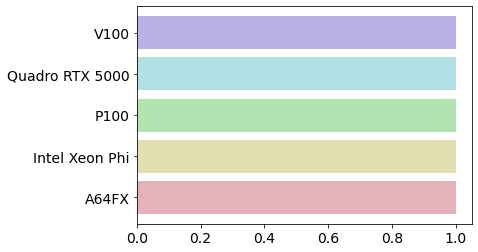

In [28]:
show_submission_colors(color_label=accelerator_short_label, color_label_range=accelerator_short_names, alpha=0.3)

### 2d visualizations

In [29]:
# Plot parameters

# x-axis

x_label = 'batch size'
x_key = 'global_batch_size'

x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

# y-axis

y_label = '# epochs to solution'
y_key = 'run_stop_epoch'
y_transform = None

y_label = 'time to solution [min]'
y_key = 'run_time'
y_transform = lambda t: t/60.
    
y_label = 'epoch throughput [1/min]'
y_key = 'run_epoch_throughput'
y_transform = lambda t: t/60.
    
def get_accelerator_hours(run_system_stats):
    return run_system_stats['run']['run_time']/3600*accelerator_number(run_system_stats['system'])

y_label = 'accelerator hours'
y_key = get_accelerator_hours
y_transform = None
    
def get_pflopsdays(run_system_stats):
    return run_system_stats['run']['run_time']/3600./24.*get_pflops(run_system_stats['system'])

y_label = 'PF/s-days'
y_key = get_pflopsdays
y_transform = None

In [30]:
# Checking for correlations of individual hyperparameters on number of epochs to converge is possible (not very helpful when everyone roughly uses the same - hence "if False")

if benchmark.name == 'cosmoflow' and False:
    x_key = lambda run_system_stats: float(run_system_stats['opt_opts']['opt_learning_rate_decay_boundary_epochs'][1])
    x_label = 'opt_learning_rate_decay_boundary_epochs[1]'
    filter_submissions = lambda submission_stat: submission_stat['division'] == 'closed'

    y_label = '# epochs to solution'
    y_key = 'run_stop_epoch'
    y_transform = None

    plot_all_submissions(x_key=x_key, x_label=x_label, y_key=y_key, y_label=y_label, y_transform=y_transform, sharey=True, filter_submissions=filter_submissions)

In [31]:
if benchmark.round == 'hpc_results_v0.7':
    batch_size_to_accelerator_ratio = 1.
elif benchmark.name == 'resnet':
    batch_size_to_accelerator_ratio = np.min([s['global_batch_size']/accelerator_number(s['system']) for s in submissions_stats.values()])
batch_size_to_accelerator_ratio

1.0

## Time to solution

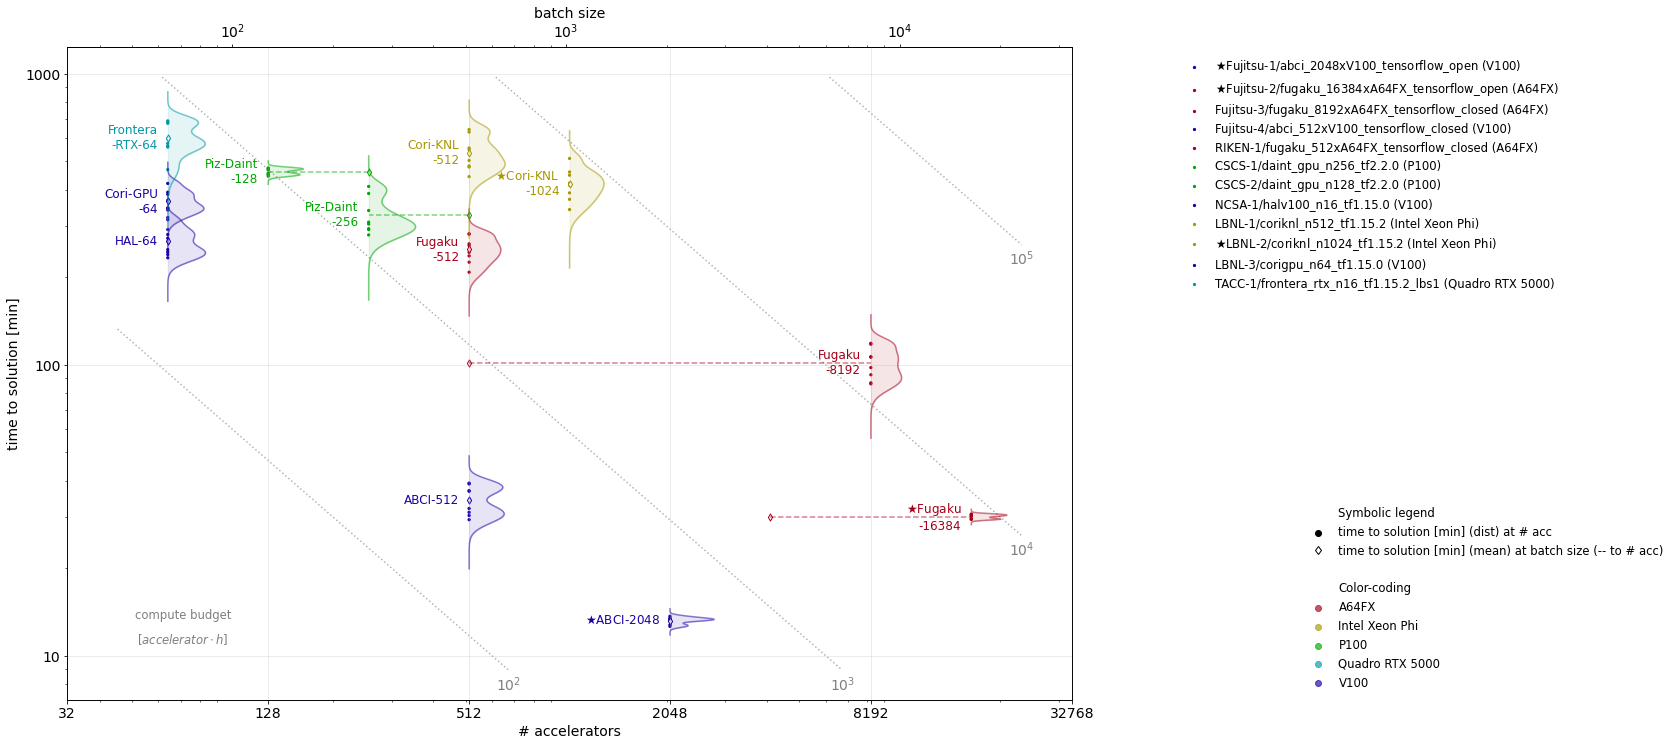

In [32]:
fig, ax = plt.subplots(ncols=1,
                       figsize=(18, 12))

# x_label = 'batch size'
# x_key = 'global_batch_size'

x_label = '# accelerators'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

secondary_x_label = 'batch size'
secondary_x_legend_label = 'time to solution [min] (mean) at batch size (-- to # acc)'
secondary_x_key = 'global_batch_size'
secondary_x_marker = 'd'

primary_to_secondary_x_transform = lambda a: a*batch_size_to_accelerator_ratio
secondary_to_primary_x_transform = lambda b: b/batch_size_to_accelerator_ratio

y_label = 'time to solution [min]'
y_legend_label = 'time to solution [min] (dist) at # acc'
y_key = 'run_time'
y_transform = lambda t: t/60.
    
plot_all_submissions(x_key=x_key, x_label=x_label, 
                     secondary_x_key=secondary_x_key, secondary_x_label=secondary_x_label, secondary_x_legend_label=secondary_x_legend_label, secondary_x_marker=secondary_x_marker,
                     y_key=y_key, y_label=y_label, y_legend_label=y_legend_label, y_transform=y_transform, 
                     primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform,
                     sharey=True, axis_scale='loglog', color_label=accelerator_short_label, color_label_range=accelerator_short_names, show_symbolic_legend=True,
                     level_func='x*y', level_label=(r'compute budget', r'$[accelerator \cdot h]$'), level_transform=(lambda l, s: l/60, lambda l, s: l*60), ax=ax)

ax.yaxis.set_major_locator(plt.LogLocator(base=10.))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
# plt.savefig(f'output/{benchmark.name}-time-to-solution.png')

In [33]:
def get_effective_epoch_samples(submissions_stats):
    submission_train_samples = np.unique([stat['train_samples'] for stat in submissions_stats.values()])
    if len(submission_train_samples) > 1:
        print("Note: different number of training samples used in different submissions! Using median of {}".format(submission_train_samples))
    submission_train_samples = np.median(submission_train_samples)


    submission_eval_samples = np.unique([stat['eval_samples'] for stat in submissions_stats.values()])
    if len(submission_eval_samples) > 1:
        print("Note: different number of evaluation samples used in different submissions! Using median of {}".format(submission_train_samples))
    submission_eval_samples = np.median(submission_eval_samples)

    mean_eff_epoch_samples = [] # handle DeepCAM separately
    submissions_runs_with_olympic_scoring = [(k, sorted(submission_stat['runs'], key=lambda run: run['run_time'])[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1]) 
                                             for k, submission_stat in submissions_stats.items()] # olympic scoring rules
    for k, runs in submissions_runs_with_olympic_scoring:
#         print(k)
#         print([runs[i]['run_epoch_samples'] for i in range(len(runs))])
#         print([len(runs[i]['run_epochs']) for i in range(len(runs))])
#         print([len(runs[i]['run_evals']) for i in range(len(runs))])
        submission_eff_epoch_samples = [runs[i]['run_avg_epoch_samples'] for i in range(len(runs))]
        if benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow':
            assert np.unique(submission_eff_epoch_samples) == np.array([submission_train_samples + submission_eval_samples])
        else:
            mean_eff_epoch_samples.append(np.mean(submission_eff_epoch_samples))
    
    if benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow':
        eff_epoch_samples = submission_train_samples + submission_eval_samples
    else:
        eff_epoch_samples = int(np.mean(mean_eff_epoch_samples))
    return eff_epoch_samples


In [34]:
if benchmark.round == 'hpc_results_v0.7':
    accelerators_to_epoch_throughput_ratio = 1000./1.
elif benchmark.name == 'resnet':
    accelerators_to_epoch_throughput_ratio = 1000./75.
accelerators_to_epoch_throughput_ratio

# np.mean([s['train_samples'] for s in submissions_stats.values()])/np.min([s['global_batch_size'] for s in submissions_stats.values()])

1000.0

In [35]:
if benchmark.round == 'hpc_results_v0.7':
    batch_size_to_epochs_ratio = 256/50.
elif benchmark.name == 'resnet':
    batch_size_to_epochs_ratio = 10000/50
batch_size_to_epochs_ratio


5.12

## All 4 of batch size, # accelerators, epoch scaling and compute throughput jointly displayed in a 2x2 matrix with shared x-/y-axes

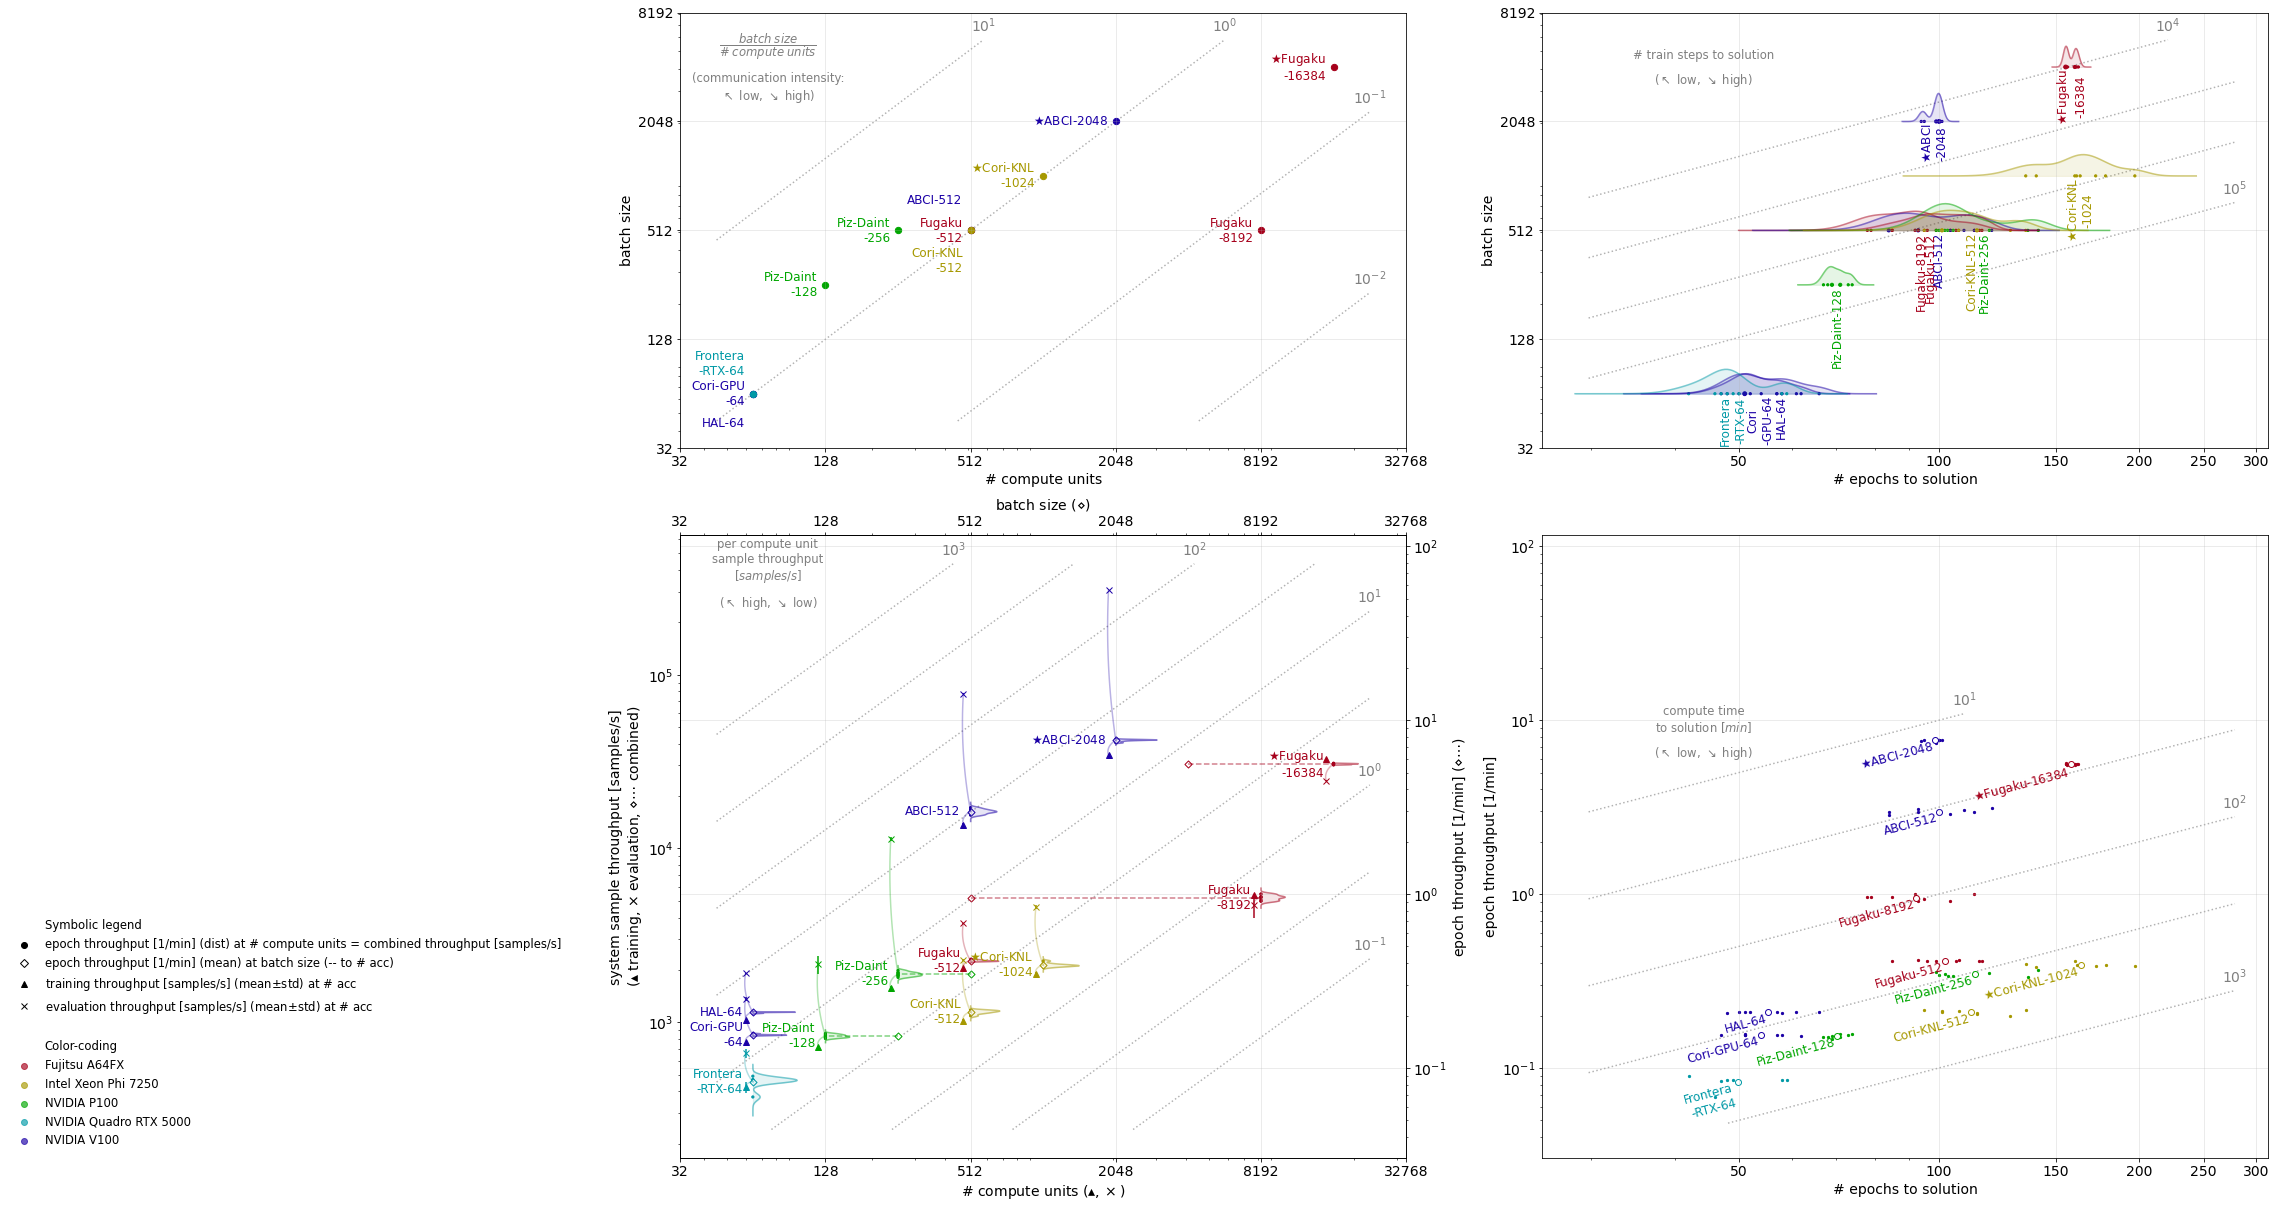

In [36]:
gridspec_kw = dict(width_ratios=(1,1), height_ratios=(1,10/7))
fig, ax = plt.subplots(nrows=2, ncols=2, #                       sharex=True, sharey=True, #sharex=True, 
                       figsize=(32, 17), gridspec_kw=gridspec_kw)
#                        figsize=(32, 22), gridspec_kw=gridspec_kw)
#                        figsize=(28, 16.5))

if benchmark.round == 'training_results_v0.7':
    filter_submissions = lambda s: s['system']['submitter'] in ['Google', 'NVIDIA'] # ['Alibaba', 'Dell EMC', 'Fujitsu', 'Google', 'Inspur', 'Intel', 'NVIDIA', 'SIAT']
else:
    filter_submissions = lambda s: True

#### 0,0

y_label = 'batch size'
y_key = 'global_batch_size'

x_label = '# compute units'
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

def submission_label_annotation_opts_parameter_choice(submission_stat):
    label = submission_stat['submission_long_label']
    if benchmark.name == 'cosmoflow':
        if label.endswith('-512'):
            y_coord = {'Cori-KNL-512': -30, 'Fugaku-512': 0, 'ABCI-512': 30}
            return dict(xytext=( -8, y_coord[label]), textcoords="offset points", ha='right', va='center', rotation=0, alpha=1., fontsize=12)        
        elif label.endswith('-64'):
            y_coord = {'HAL-64': -30, 'Cori-GPU-64': 0, 'Frontera\n-RTX-64': 30}
            return dict(xytext=( -8, y_coord[label]), textcoords="offset points", ha='right', va='center', rotation=0, alpha=1., fontsize=12)  
        else:
            return dict(xytext=( -8, 0), textcoords="offset points", ha='right', va='center', rotation=0, alpha=1., fontsize=12)  
    elif benchmark.name == 'deepcam':
        if label.endswith('-1024'):
            return dict(xytext=( -8,15 if submission_stat['division'] == 'open' else -15), textcoords="offset points", ha='right', va='center', rotation=0, alpha=1., fontsize=12)        
        else:
            return dict(xytext=( -8, 0), textcoords="offset points", ha='right', va='center', rotation=0, alpha=1., fontsize=12)  
    else:
        return dict(xytext=( -8, 0), textcoords="offset points", ha='right', va='center', rotation=0, alpha=1., fontsize=12)  

submission_label_annotation_opts = submission_label_annotation_opts_parameter_choice

plot_all_submissions_flipped(x_key=x_key, x_label=x_label,
                     y_key=y_key, y_label=y_label, 
                     level_func='y/x', level_label=(r'$\dfrac{batch\; size}{\#\; compute\; units}$', '(communication intensity:\n' + r'$\nwarrow$ low, $\searrow$ high)'), level_log_base=10., 
                     sharey=True, axis_scale='loglog', color_label=accelerator_short_label, color_label_range=accelerator_short_names,
                     format_x_axis_as_y_axis=True, 
                     filter_submissions=filter_submissions,
                     submission_annotation_key='submission_long_label' if benchmark.name == 'deepcam' else 'submission_short_label', 
                     submission_label_annotation_opts=submission_label_annotation_opts, ax=ax[0,0])

#### 1,0

secondary_x_label = r'batch size ($\diamond$)' + '\n '
secondary_x_legend_label = 'epoch throughput [1/min] (mean) at batch size (-- to # acc)'
secondary_x_key = 'global_batch_size'
secondary_x_marker = 'D' # matplotlib.markers.MarkerStyle(marker='D', fillstyle='none')

x_label = r'# compute units ($\blacktriangle, \times$' + (')' if benchmark.name == 'cosmoflow' else r', $\mathbf{+}$)')
x_key = lambda submission_stat: accelerator_number(submission_stat['system'])

primary_to_secondary_x_transform = lambda a: a*batch_size_to_accelerator_ratio
secondary_to_primary_x_transform = lambda b: b/batch_size_to_accelerator_ratio

# TODO: epoch time

y_label = 'epoch throughput [1/min] ($\diamond  \cdots$)'
y_legend_label = 'epoch throughput [1/min] (dist) at # compute units = combined throughput [samples/s]' if benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow' else 'epoch throughput [1/min] (dist) at # acc'
y_key = 'run_epoch_throughput'
y_transform = lambda t: t*60.

secondary_y_keys = []
secondary_y_legend_labels = []
secondary_y_transforms = []
secondary_y_markers = []

secondary_y_keys.append('run_train_throughput')
secondary_y_transforms.append(lambda t: t) #*60.
secondary_y_markers.append('^')
secondary_y_legend_labels.append(r'training throughput [samples/s] (mean$\pm$std) at # acc')

secondary_y_keys.append('run_eval_throughput')
secondary_y_transforms.append(lambda t: t) #*60.
secondary_y_markers.append('x')
secondary_y_legend_labels.append(r'evaluation throughput [samples/s] (mean$\pm$std) at # acc')

if not(benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow'):
    secondary_y_keys.append('run_avg_epoch_sample_throughput')
    secondary_y_transforms.append(lambda t: t) #*60.
    secondary_y_markers.append('P')
    secondary_y_legend_labels.append(r'average throughput [samples/s] (mean$\pm$std) at # acc')
    
# if benchmark.round == 'hpc_results_v0.7':
#     secondary_y_keys.append('run_staging_throughput')
#     secondary_y_transforms.append(lambda t: t) #*60.
#     secondary_y_markers.append('s')
#     secondary_y_legend_labels.append(r'staging throughput [samples/s] (mean$\pm$std) at # acc')
    
secondary_y_axis_label = 'system sample throughput [samples/s]\n' + r'($\blacktriangle$ training, $\times$ evaluation, ' + (r'$\diamond \cdots$' if benchmark.name == 'cosmoflow' else r'$\mathbf{+} $') + ' combined)'

eff_epoch_samples = get_effective_epoch_samples(submissions_stats)
primary_to_secondary_y_transform = lambda et: et*float(eff_epoch_samples)/60. 
secondary_to_primary_y_transform = lambda st: st/float(eff_epoch_samples)*60.

# Epoch throughput w/o initial phase, i.e. staging overhead not shown (makes very minor difference, probably worth mentioning in text rather)

level_func='y/x' 
level_label=('per compute unit\nsample throughput\n' + r'$[samples/s]$', r'($\nwarrow$ high, $\searrow$ low)') #('per-compute-unit\nsample throughput\n' + r'($\nwarrow$ high, $\searrow$ low)', r'$[samples/s]$') #(r'$\dfrac{combined\ throughput}{\#\ compute\ units}$', r'$[samples/s]$')
level_transform=(primary_to_secondary_y_transform, secondary_to_primary_y_transform)

plot_all_submissions(y_key=y_key, y_label=y_label, y_transform=y_transform, y_legend_label=y_legend_label, 
                     secondary_y_keys=secondary_y_keys, secondary_y_axis_label=secondary_y_axis_label, secondary_y_legend_labels=secondary_y_legend_labels, secondary_y_transforms=secondary_y_transforms, secondary_y_markers=secondary_y_markers,
                     primary_to_secondary_y_transform=primary_to_secondary_y_transform, secondary_to_primary_y_transform=secondary_to_primary_y_transform,
                     x_key=x_key, x_label=x_label,
                     secondary_x_key=secondary_x_key, secondary_x_label=secondary_x_label, secondary_x_legend_label=secondary_x_legend_label, secondary_x_marker=secondary_x_marker, secondary_x_ticks_same_as_primary=True,
                     primary_to_secondary_x_transform=primary_to_secondary_x_transform, secondary_to_primary_x_transform=secondary_to_primary_x_transform, 
                     sharey=False, axis_scale='loglog', color_label=accelerator_short_label, color_label_range=accelerator_short_names, legend_side='left', show_symbolic_legend=True,
                     level_func=level_func, level_label=level_label, level_transform=level_transform, level_fine_grid=2, filter_submissions=filter_submissions, 
                     submission_annotation_key='submission_long_label' if benchmark.name == 'deepcam' else 'submission_short_label', 
                     color_legend_label=color_legend_label, ax=ax[1,0])        

### 0,1

y_label = 'batch size'
y_key = 'global_batch_size'

x_label = '# epochs to solution'
x_key = 'run_stop_epoch'
x_transform = None

def submission_label_annotation_opts_epoch_scaling(submission_stat):
    label = submission_stat['submission_long_label']
    if benchmark.name == 'cosmoflow':
        if label == 'Piz-Daint-256':
            return dict(xytext=( 10, -2),
                        textcoords="offset points",
                        ha='center', va='top', rotation=90,      
                        alpha=1., fontsize=12)        
        elif label in ['HAL-64']:
            return dict(xytext=( 13, -2),
                        textcoords="offset points",
                        ha='center', va='top', rotation=90,      
                        alpha=1., fontsize=12)        
        elif label in ['Fugaku-512']:
            return dict(xytext=( -15, -2),
                        textcoords="offset points",
                        ha='center', va='top', rotation=90,      
                        alpha=1., fontsize=12)        
        elif label in ['Fugaku-8192']:
            return dict(xytext=( 5, -2),
                        textcoords="offset points",
                        ha='center', va='top', rotation=90,      
                        alpha=1., fontsize=12)        
        elif 'Frontera' in label:
            return dict(xytext=( -5, -2),
                        textcoords="offset points",
                        ha='center', va='top', rotation=90,      
                        alpha=1., fontsize=12)        
        else:
            return dict(xytext=( 0, -2),
                        textcoords="offset points",
                        ha='center', va='top', rotation=90,      
                        alpha=1., fontsize=12)
    elif benchmark.name == 'deepcam':
        if label.endswith('-1024'):
            return dict(xytext=( -3 if submission_stat['division'] == 'open' else 3, -2.5),
                        textcoords="offset points",
                        ha='center', va='top', rotation=90,      
                        alpha=1., fontsize=12)        
        else:
            return dict(xytext=( 0, -2.5),
                        textcoords="offset points",
                        ha='center', va='top', rotation=90,      
                        alpha=1., fontsize=12)
    else:
        return dict(xytext=( 0, -2.5),
                    textcoords="offset points",
                    ha='center', va='top', rotation=90,      
                    alpha=1., fontsize=12)
        
submission_label_annotation_opts = submission_label_annotation_opts_epoch_scaling
plot_all_submissions_flipped(y_key=y_key, y_label=y_label, 
                     x_key=x_key, x_label=x_label, x_transform=x_transform, 
                     level_func='x/y', level_label=('# train steps to solution', r'($\nwarrow$ low, $\searrow$ high)'), 
                     level_transform=(lambda l, s: l*s['train_samples'], lambda l, s: l/s['train_samples']), level_fine_grid=3,
                     sharey=True, axis_scale='loglog', color_label=accelerator_short_label, color_label_range=accelerator_short_names, filter_submissions=filter_submissions, 
                     submission_annotation_key='submission_epochs_label',
                     submission_label_annotation_opts=submission_label_annotation_opts, ax=ax[0,1])

ax[0,1].xaxis.set_major_locator(plt.AutoLocator())
ax[0,1].xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
ax[0,1].yaxis.set_major_locator(plt.LogLocator(base=2.))
ax[0,1].yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

### 1,1

x_label = '# epochs to solution'
x_key = 'run_stop_epoch'
x_transform = None

y_label = 'epoch throughput [1/min]'
y_key = 'run_epoch_throughput'
y_transform = lambda t: t*60.
    
level_func='x/y' 
level_label=('compute time\nto solution' + r' $[min]$', r'($\nwarrow$ low, $\searrow$ high)') #('compute time \nto solution\n' + r'($\nwarrow$ low, $\searrow$ high)', r'$[min]$')

submission_label_annotation_opts = dict(
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='right', va='top',  rotation=14.75,
                    alpha=1., fontsize=12)

plot_all_submissions_scatter_vector(x_key=x_key, x_label=x_label, x_transform=x_transform, #secondary_x_label=secondary_x_label, secondary_x_key=secondary_x_key, 
                                    y_key=y_key, y_label=y_label, y_transform=y_transform,
                                    xy_mean_marker='o',
                                    sharey=True, axis_scale='loglog', color_label=accelerator_short_label, color_label_range=accelerator_short_names,
                                    level_func=level_func, level_label=level_label, level_fine_grid=2,
                                    filter_submissions=filter_submissions,
                                    submission_annotation_key='submission_long_label',
                                    submission_label_annotation_opts=submission_label_annotation_opts,
                                    ax=ax[1,1])

ax[1,1].xaxis.set_major_locator(plt.AutoLocator())
ax[1,1].xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[0,0].set_ylim(ax[0,1].get_ylim())

ax[1,1].set_xlim(ax[0,1].get_xlim())
ax[1,1].set_ylim(ax[1,0].get_ylim())

ax[0,0].legend().set_visible(False)
ax[0,1].legend().set_visible(False)
ax[1,0].legend().set_visible(False)
ax[1,1].legend().set_visible(False)

fig.tight_layout()
# plt.savefig(f'output/{benchmark.name}-2x2-batch-size-acc-epochs-throughput-efficiency-vertical.png', dpi=300)

# Tabular analysis

In [37]:
def olympic_scoring_of_runs(runs):
    return sorted(runs, key=lambda run: run['run_time'])[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1] # olympic scoring rules (discards the best and worst run (if invalid should be skipped at parsing))

from copy import deepcopy
submissions_stats_olympic = deepcopy(submissions_stats)
for k in submissions_stats_olympic:
    submissions_stats_olympic[k]['runs'] = olympic_scoring_of_runs(submissions_stats_olympic[k]['runs']) # olympic scoring rules
# len(submissions_stats_olympic['../hpc_results_v0.7/Fujitsu/results/abci_2048xV100_tensorflow_open/cosmoflow']['runs'])
# len(submissions_stats['../hpc_results_v0.7/Fujitsu/results/abci_2048xV100_tensorflow_open/cosmoflow']['runs'])

In [38]:
submissions_stats_df = pd.DataFrame.from_dict(submissions_stats_olympic, orient='index').sort_values(['division'])

In [39]:
pd.set_option('display.max_columns', None)
def visualize_submissions_by_opt(submissions_stats_df_opt_vis, sort_keys=['global_batch_size']):
    if benchmark.round == 'training_results_v0.7':
        display(submissions_stats_df_opt_vis[(submissions_stats_df_opt_vis['division'] == 'closed') & (submissions_stats_df_opt_vis['opt_name'] == 'sgd')].drop(columns=[c for c in submissions_stats_df_opt_vis.columns if c.startswith('lars_')]).sort_values(sort_keys))
        display(submissions_stats_df_opt_vis[(submissions_stats_df_opt_vis['division'] == 'closed') & (submissions_stats_df_opt_vis['opt_name'] == 'lars')].drop(columns=[c for c in submissions_stats_df_opt_vis.columns if c.startswith('sgd_') or c == 'model_bn_span' or c == 'opt_learning_rate_warmup_epochs']).sort_values(sort_keys))
        display(submissions_stats_df_opt_vis[(submissions_stats_df_opt_vis['division'] == 'open')].sort_values(sort_keys))
    else:
        display(submissions_stats_df_opt_vis.sort_values(['division'] + sort_keys))

### Runtime statistics

In [40]:
def throughput_aware_mean(run_metric):
    if not run_metric.name.endswith('throughput'):
        return run_metric.mean()
    else:
        return 1./(1./run_metric).mean()

def throughput_aware_std(run_metric):
    if not run_metric.name.endswith('throughput'):
        return run_metric.std()
    else:
        mean = throughput_aware_mean(run_metric)
        return 1./(1./mean - (1./run_metric).std()) - mean

submissions_stats_df_run_mean = submissions_stats_df['runs'].apply(lambda expt: pd.DataFrame.from_dict(expt).apply(throughput_aware_mean)).add_suffix('.mean')
submissions_stats_df_run_mean.index = submissions_stats_df.index
submissions_stats_df_run_std = submissions_stats_df['runs'].apply(lambda expt: pd.DataFrame.from_dict(expt).apply(throughput_aware_std)).add_suffix('.std')
submissions_stats_df_run_std.index = submissions_stats_df.index
submissions_stats_df_run = submissions_stats_df_run_mean.join(submissions_stats_df_run_std)

for c in submissions_stats_df_run.columns: # transform units from seconds to minutes
    if 'throughput' in c:
        submissions_stats_df_run[c] *= 60.
    elif 'time' in c:
        submissions_stats_df_run[c] /= 60.

submissions_stats_df_run['staging_time/run_time'] = submissions_stats_df_run.apply(lambda row: row['run_staging_time.mean']/row['run_time.mean'], axis=1)
submissions_stats_df_run['train_time/run_time']   = submissions_stats_df_run.apply(lambda row: row['run_train_time.mean']/row['run_time.mean'], axis=1)
submissions_stats_df_run['eval_time/run_time']    = submissions_stats_df_run.apply(lambda row: row['run_eval_time.mean']/row['run_time.mean'], axis=1)

submissions_stats_df_run = submissions_stats_df_run[sorted(submissions_stats_df_run.columns)]
submissions_stats_df_run.index = submissions_stats_df.index
submissions_stats_df_run

submissions_stats_df_run_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'opt_opts', 'system']).join(submissions_stats_df_run).set_index('submission_label').sort_values(['division', 'global_batch_size'])
submissions_stats_df_run_vis
#visualize_submissions_by_opt(submissions_stats_df_run_vis)
# submissions_stats_df_run_vis[['run_time.mean', 'staging_time/run_time', 'train_time/run_time', 'eval_time/run_time']] 

,global_batch_size,opt_name,train_samples,eval_samples,division,submission_long_label,submission_epochs_label,eval_time/run_time,run_avg_epoch_sample_throughput.mean,run_avg_epoch_sample_throughput.std,run_avg_epoch_samples.mean,run_avg_epoch_samples.std,run_epoch_throughput.mean,run_epoch_throughput.std,run_epoch_time.mean,run_epoch_time.std,run_eval_throughput.mean,run_eval_throughput.std,run_eval_time.mean,run_eval_time.std,run_num_evals.mean,run_num_evals.std,run_staging_throughput.mean,run_staging_throughput.std,run_staging_time.mean,run_staging_time.std,run_stop_epoch.mean,run_stop_epoch.std,run_time.mean,run_time.std,run_train_throughput.mean,run_train_throughput.std,run_train_time.mean,run_train_time.std,staging_time/run_time,train_time/run_time
submission_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NCSA-1/halv100_n16_tf1.15.0,64,SGD,262144,65536,closed,HAL-64,HAL-64,0.118832,6.836679e+04,450.069230,327680.0,0.0,0.208639,0.001374,4.792970,0.031347,1.149575e+05,647.546622,31.560327,3.442042,55.375,6.186102,NaN,NaN,NaN,NaN,55.375,6.186102,265.588892,29.029477,6.207705e+04,491.535952,233.786254,25.605725,NaN,0.880256
LBNL-3/corigpu_n64_tf1.15.0,64,SGD,262144,65536,closed,Cori-GPU-64,Cori\n-GPU-64,0.119187,5.071813e+04,390.046660,327680.0,0.0,0.154779,0.001190,6.460806,0.049307,8.124480e+04,2201.941285,43.470850,4.244788,53.875,4.853202,1.986662e+04,756.791742,16.493996,0.605260,53.875,4.853202,364.728419,32.772234,4.636305e+04,333.312678,304.705179,28.705647,0.045223,0.835430
TACC-1/frontera_rtx_n16_tf1.15.2_lbs1,64,SGD,262144,65536,closed,Frontera\n-RTX-64,Frontera\n-RTX-64,0.136690,2.711159e+04,2661.737233,327680.0,0.0,0.082738,0.008123,12.086343,1.080520,3.965195e+04,3012.039141,82.318552,9.828208,49.875,5.841661,NaN,NaN,NaN,NaN,49.875,5.841661,602.226419,76.662003,2.512507e+04,2587.387497,519.516894,67.265124,NaN,0.862660
CSCS-2/daint_gpu_n128_tf2.2.0,256,SGD,262144,65536,closed,Piz-Daint-128,Piz-Daint-128,0.078003,4.993060e+04,1120.366693,327680.0,0.0,0.152376,0.003419,6.562709,0.144025,1.276454e+05,18059.483129,35.960010,3.569146,70.250,2.434866,NaN,NaN,NaN,NaN,70.250,2.434866,461.008594,11.784575,4.333470e+04,809.508191,424.864046,13.430447,NaN,0.921597
Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed,512,SGD,262144,65536,closed,Fugaku-8192,Fugaku-8192,0.216264,3.124162e+05,11685.546668,327680.0,0.0,0.953419,0.035661,1.048857,0.037817,2.754002e+05,52756.501464,21.948615,4.484686,92.375,11.999256,8.701360e+04,13743.753990,3.765848,0.513678,92.375,11.999256,101.490063,12.864696,3.232790e+05,1677.332947,74.929381,9.932865,0.037106,0.738293
Fujitsu-4/abci_512xV100_tensorflow_closed,512,SGD,262144,65536,closed,ABCI-512,ABCI-512,0.040888,9.772490e+05,32826.794474,327680.0,0.0,2.982327,0.100179,0.335309,0.010897,4.665718e+06,20939.634571,1.404044,0.184687,100.000,13.501323,4.296832e+05,2318.398163,0.762608,0.004093,100.000,13.501323,34.338990,4.032189,8.159811e+05,28570.056425,32.059704,3.865201,0.022208,0.933624
RIKEN-1/fugaku_512xA64FX_tensorflow_closed,512,SGD,262144,65536,closed,Fugaku-512,Fugaku-512,0.120214,1.354230e+05,1180.764370,327680.0,0.0,0.413278,0.003603,2.419677,0.020915,2.232561e+05,1664.623378,29.974894,3.148816,102.125,10.829028,2.119043e+05,15525.523508,1.546358,0.105562,102.125,10.829028,249.346260,26.020881,1.232963e+05,1136.990003,217.111106,22.880496,0.006202,0.870721
CSCS-1/daint_gpu_n256_tf2.2.0,512,SGD,262144,65536,closed,Piz-Daint-256,Piz-Daint-256,0.033174,1.134398e+05,3395.427037,327680.0,0.0,0.346191,0.010362,2.888582,0.083947,6.818147e+05,18407.559176,10.848135,1.425026,113.125,16.898330,NaN,NaN,NaN,NaN,113.125,16.898330,327.007198,48.134920,9.387559e+04,2891.047118,315.724979,46.734225,NaN,0.965499
LBNL-1/coriknl_n512_tf1.15.2,512,SGD,262144,65536,closed,Cori-KNL-512,Cori-KNL-512,0.099655,6.862598e+04,1799.484100,327680.0,0.0,0.209430,0.005492,4.774868,0.122006,1.372437e+05,2328.117419,53.421294,6.630573,111.875,13.881514,NaN,NaN,NaN,NaN,111.875,13.881514,536.062200,72.641496,6.100128e+04,1805.1

In [41]:
# print((submissions_stats_df_run_vis[submissions_stats_df_run_vis['global_batch_size'] <= 1024]['run_time.std']/submissions_stats_df_run_vis[submissions_stats_df_run_vis['global_batch_size'] <= 1024]['run_time.mean']).mean()) #.to_latex(float_format="{:0.2f}".format)) #, 'staging_time/run_time', 'train_time/run_time', 'eval_time/run_time']] 
# submissions_stats_df_run_vis.loc['CSCS-1/daint_gpu_n256_tf2.2.0',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/2./submissions_stats_df_run_vis.loc['CSCS-2/daint_gpu_n128_tf2.2.0',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
# submissions_stats_df_run_vis.loc['LBNL-2/coriknl_n1024_tf1.15.2',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/2./submissions_stats_df_run_vis.loc['LBNL-1/coriknl_n512_tf1.15.2',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
# submissions_stats_df_run_vis.loc['Fujitsu-1/abci_2048xV100_tensorflow_open',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/4./submissions_stats_df_run_vis.loc['Fujitsu-4/abci_512xV100_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
# submissions_stats_df_run_vis.loc['Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/16./submissions_stats_df_run_vis.loc['RIKEN-1/fugaku_512xA64FX_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
# submissions_stats_df_run_vis.loc['Fujitsu-2/fugaku_16384xA64FX_tensorflow_open',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/8./4./submissions_stats_df_run_vis.loc['RIKEN-1/fugaku_512xA64FX_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
# submissions_stats_df_run_vis.loc['LBNL-3/corigpu_n64_tf1.15.0',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]*8./submissions_stats_df_run_vis.loc['Fujitsu-4/abci_512xV100_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
# submissions_stats_df_run_vis.loc['NCSA-1/halv100_n16_tf1.15.0',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]*8./submissions_stats_df_run_vis.loc['Fujitsu-4/abci_512xV100_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
# submissions_stats_df_run_vis.loc['Fujitsu-4/abci_512xV100_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/8./submissions_stats_df_run_vis.loc['LBNL-3/corigpu_n64_tf1.15.0',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
# submissions_stats_df_run_vis.loc['Fujitsu-4/abci_512xV100_tensorflow_closed',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/8./submissions_stats_df_run_vis.loc['NCSA-1/halv100_n16_tf1.15.0',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
# submissions_stats_df_run_vis.loc['NCSA-1/halv100_n16_tf1.15.0',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]/submissions_stats_df_run_vis.loc['LBNL-3/corigpu_n64_tf1.15.0',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]
# submissions_stats_df_run_vis.loc['LBNL-1/corigpu_n64_pt1.6.0',['run_train_throughput.mean', 'run_eval_throughput.mean',  'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]*16./submissions_stats_df_run_vis.loc['Fujitsu-1/abci_1024xV100_pytorch_closed',['run_train_throughput.mean', 'run_eval_throughput.mean', 'run_avg_epoch_sample_throughput.mean', 'run_epoch_throughput.mean']]


## Data staging analysis

,global_batch_size,opt_name,train_samples,eval_samples,division,submission_long_label,submission_epochs_label,eval_time/run_time,run_avg_epoch_sample_throughput.mean,run_avg_epoch_sample_throughput.std,run_avg_epoch_samples.mean,run_avg_epoch_samples.std,run_epoch_throughput.mean,run_epoch_throughput.std,run_epoch_time.mean,run_epoch_time.std,run_eval_throughput.mean,run_eval_throughput.std,run_eval_time.mean,run_eval_time.std,run_num_evals.mean,run_num_evals.std,run_staging_throughput.mean,run_staging_throughput.std,run_staging_time.mean,run_staging_time.std,run_stop_epoch.mean,run_stop_epoch.std,run_time.mean,run_time.std,run_train_throughput.mean,run_train_throughput.std,run_train_time.mean,run_train_time.std,staging_time/run_time,train_time/run_time
submission_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CSCS-2/daint_gpu_n128_tf2.2.0,256,SGD,262144,65536,closed,Piz-Daint-128,Piz-Daint-128,0.078003,4.993060e+04,1120.366693,327680.0,0.0,0.152376,0.003419,6.562709,0.144025,1.276454e+05,18059.483129,35.960010,3.569146,70.250,2.434866,NaN,NaN,NaN,NaN,70.250,2.434866,461.008594,11.784575,4.333470e+04,809.508191,424.864046,13.430447,NaN,0.921597
CSCS-1/daint_gpu_n256_tf2.2.0,512,SGD,262144,65536,closed,Piz-Daint-256,Piz-Daint-256,0.033174,1.134398e+05,3395.427037,327680.0,0.0,0.346191,0.010362,2.888582,0.083947,6.818147e+05,18407.559176,10.848135,1.425026,113.125,16.898330,NaN,NaN,NaN,NaN,113.125,16.898330,327.007198,48.134920,9.387559e+04,2891.047118,315.724979,46.734225,NaN,0.965499
Fujitsu-4/abci_512xV100_tensorflow_closed,512,SGD,262144,65536,closed,ABCI-512,ABCI-512,0.040888,9.772490e+05,32826.794474,327680.0,0.0,2.982327,0.100179,0.335309,0.010897,4.665718e+06,20939.634571,1.404044,0.184687,100.000,13.501323,4.296832e+05,2318.398163,0.762608,0.004093,100.000,13.501323,34.338990,4.032189,8.159811e+05,28570.056425,32.059704,3.865201,0.022208,0.933624
Fujitsu-1/abci_2048xV100_tensorflow_open,2048,SGD,262144,65536,open,ABCI-2048,ABCI\n-2048,0.026648,2.507476e+06,34497.370077,327680.0,0.0,7.652208,0.105278,0.130681,0.001773,1.833528e+07,34268.339431,0.352073,0.009318,98.500,2.563480,1.611145e+06,30360.498110,0.203383,0.003762,98.500,2.563480,13.211758,0.353403,2.062390e+06,29208.552167,12.519269,0.339177,0.015394,0.947585
RIKEN-1/fugaku_512xA64FX_tensorflow_closed,512,SGD,262144,65536,closed,Fugaku-512,Fugaku-512,0.120214,1.354230e+05,1180.764370,327680.0,0.0,0.413278,0.003603,2.419677,0.020915,2.232561e+05,1664.623378,29.974894,3.148816,102.125,10.829028,2.119043e+05,15525.523508,1.546358,0.105562,102.125,10.829028,249.346260,26.020881,1.232963e+05,1136.990003,217.111106,22.880496,0.006202,0.870721
Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed,512,SGD,262144,65536,closed,Fugaku-8192,Fugaku-8192,0.216264,3.124162e+05,11685.546668,327680.0,0.0,0.953419,0.035661,1.048857,0.037817,2.754002e+05,52756.501464,21.948615,4.484686,92.375,11.999256,8.701360e+04,13743.753990,3.765848,0.513678,92.375,11.999256,101.490063,12.864696,3.232790e+05,1677.332947,74.929381,9.932865,0.037106,0.738293
Fujitsu-2/fugaku_16384xA64FX_tensorflow_open,4096,SGDWD,262144,65536,open,Fugaku-16384,Fugaku\n-16384,0.234901,1.834009e+06,11972.124177,327680.0,0.0,5.596951,0.036536,0.178669,0.001159,1.465770e+06,9977.362135,7.064260,0.138964,158.000,3.023716,3.722033e+05,36051.575179,0.880379,0.077743,158.000,3.023716,30.073371,0.506072,1.956916e+06,14188.827466,21.166015,0.469785,0.029274,0.703813
LBNL-3/corigpu_n64_tf1.15.0,64,SGD,262144,65536,closed,Cori-GPU-64,Cori\n-GPU-64,0.119187,5.071813e+04,390.046660,327680.0,0.0,0.154779,0.001190,6.460806,0.049307,8.124480e+04,2201.941285,43.470850,4.244788,53.875,4.853202,1.986662e+04,756.791742,16.493996,0.605260,53.875,4.853202,364.728419,32.772234,4.636305e+04,333.312678,304.705179,28.705647,0.045223,0.835430
LBNL-1/coriknl_n512_tf1.15.2,512,SGD,262144,65536,closed,Cori-KNL-512,Cori-KNL-512,0.099655,6.862598e+04,1799.484100,327680.0,0.0,0.209430,0.005492,4.774868,0.122006,1.372437e+05,2328.117419,53.421294,6.630573,111.8

,staging_time/run_time,eval_time/run_time,train_time/run_time
submission_label,,,
CSCS-2/daint_gpu_n128_tf2.2.0,NaN,0.078003,0.921597
CSCS-1/daint_gpu_n256_tf2.2.0,NaN,0.033174,0.965499
Fujitsu-4/abci_512xV100_tensorflow_closed,0.022208,0.040888,0.933624
Fujitsu-1/abci_2048xV100_tensorflow_open,0.015394,0.026648,0.947585
RIKEN-1/fugaku_512xA64FX_tensorflow_closed,0.006202,0.120214,0.870721
Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed,0.037106,0.216264,0.738293
Fujitsu-2/fugaku_16384xA64FX_tensorflow_open,0.029274,0.234901,0.703813
LBNL-3/corigpu_n64_tf1.15.0,0.045223,0.119187,0.835430
LBNL-1/coriknl_n512_tf1.15.2,NaN,0.099655,0.897949


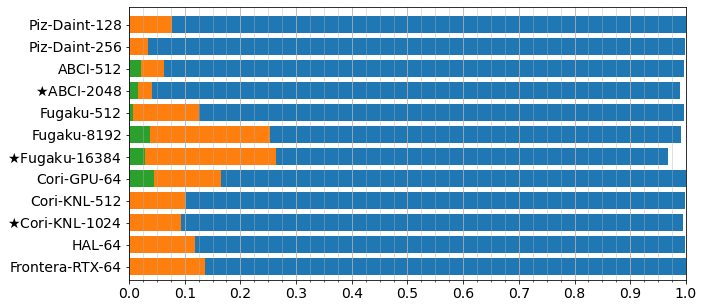

In [42]:
if benchmark.round == 'hpc_results_v0.7':
    if benchmark.name == 'cosmoflow':
        submissions_stats_df_run_vis_cosmoflow = submissions_stats_df_run_vis
        submissions_stats_df_run_vis_cosmoflow = submissions_stats_df_run_vis_cosmoflow.reindex([
            'CSCS-2/daint_gpu_n128_tf2.2.0',
            'CSCS-1/daint_gpu_n256_tf2.2.0', 
            'Fujitsu-4/abci_512xV100_tensorflow_closed',
            'Fujitsu-1/abci_2048xV100_tensorflow_open',
            'RIKEN-1/fugaku_512xA64FX_tensorflow_closed',
            'Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed',
            'Fujitsu-2/fugaku_16384xA64FX_tensorflow_open',
            'LBNL-3/corigpu_n64_tf1.15.0',
            'LBNL-1/coriknl_n512_tf1.15.2',
            'LBNL-2/coriknl_n1024_tf1.15.2',
            'NCSA-1/halv100_n16_tf1.15.0', 
            'TACC-1/frontera_rtx_n16_tf1.15.2_lbs1'])
        submissions_stats_df_run_vis_all = submissions_stats_df_run_vis_cosmoflow
    else:
        submissions_stats_df_run_vis_deepcam = submissions_stats_df_run_vis.reindex([
            'LBNL-1/corigpu_n64_pt1.6.0', 
            'Fujitsu-1/abci_1024xV100_pytorch_closed',
            'Fujitsu-2/abci_1024xV100_fjpytorch_open'])
        submissions_stats_df_run_vis_all = submissions_stats_df_run_vis_deepcam
        if 'submissions_stats_df_run_vis_cosmoflow' in locals():
            submissions_stats_df_run_vis_all = pd.concat([submissions_stats_df_run_vis_cosmoflow, submissions_stats_df_run_vis_deepcam])
    display(submissions_stats_df_run_vis_all)
#     print(submissions_stats_df_run_system_subset_vis_all.drop(['run_staging_time.mean', 'run_train_time.mean', 'run_eval_time.mean', 'run_time.mean'], axis=1).to_latex(float_format="{:0.3f}".format))
#     print(submissions_stats_df_run_vis_all[['staging_time/run_time', 'eval_time/run_time', 'train_time/run_time']].to_latex(float_format="{:0.3f}".format))
    display(submissions_stats_df_run_vis_all[['staging_time/run_time', 'eval_time/run_time', 'train_time/run_time']])

    def create_relative_time_plot(df, ax, split=None):
        ind = np.arange(len(df.index), 0, -1) + 0.0
        if split is not None:
            ind[:split] += .66

        ax.barh(ind, df['eval_time/run_time'] + df['train_time/run_time'] + df['staging_time/run_time'].apply(lambda val: 0. if pd.isnull(val) else val), label='train')
        ax.barh(ind, df['eval_time/run_time'] + df['staging_time/run_time'].apply(lambda val: 0. if pd.isnull(val) else val), label='eval')
        ax.barh(ind, df['staging_time/run_time'].apply(lambda val: 0. if pd.isnull(val) else val), label='staging')

        # ax.axhline(0, color='grey', linewidth=0.8)
        ax.set_yticks(ind)
        ax.set_yticklabels(df.apply(lambda row: (r'$\bigstar$' if row['division'] == 'open' else '') + row['submission_long_label'].replace('\n',''), axis=1))
        # ax.legend()
        ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
        # ax.set_xscale('log')
        # ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        ax.set_xticks(np.linspace(0,1.,41), minor=True)
        ax.set_xlim([0,1])
        ax.grid(True, which='major', axis='x', alpha=1.)
        ax.grid(True, which='minor', axis='x', alpha=0.5)
        ax.set_ylim(0.4,df.shape[0] + 0.8 + (0. if split is None else 0.5))
        
    fig, ax = plt.subplots(figsize=(10,4.5))
    if 'submissions_stats_df_run_vis_cosmoflow' in locals() and 'submissions_stats_df_run_vis_deepcam' in locals():
        create_relative_time_plot(submissions_stats_df_run_vis_all, ax, split=int(-submissions_stats_df_run_vis_deepcam.shape[0]))
    else:
        create_relative_time_plot(submissions_stats_df_run_vis_all, ax, split=None)        
    fig.tight_layout()
#     plt.savefig('output/results-relative-staging-eval-training-times.png', dpi=300)
        
#     ind = np.arange(len(submissions_stats_df_run_vis_all.index), 0, -1)

#     ax.barh(ind, submissions_stats_df_run_vis_all['eval_time/run_time'] + submissions_stats_df_run_vis_all['train_time/run_time'] + submissions_stats_df_run_vis_all['staging_time/run_time'].apply(lambda val: 0. if pd.isnull(val) else val), label='train')
#     ax.barh(ind, submissions_stats_df_run_vis_all['eval_time/run_time'] + submissions_stats_df_run_vis_all['staging_time/run_time'].apply(lambda val: 0. if pd.isnull(val) else val), label='eval')
#     ax.barh(ind, submissions_stats_df_run_vis_all['staging_time/run_time'].apply(lambda val: 0. if pd.isnull(val) else val), label='staging')

#     # ax.axhline(0, color='grey', linewidth=0.8)
#     ax.set_yticks(ind)
#     ax.set_yticklabels(submissions_stats_df_run_vis_all.apply(lambda row: (r'$\bigstar$' if row['division'] == 'open' else '') + row['submission_long_label'].replace('\n',''), axis=1))
#     # ax.legend()
#     ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
#     # ax.set_xscale('log')
#     # ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
#     ax.set_xticks(np.linspace(0,1.,41), minor=True)
#     ax.set_xlim([0,1])
#     ax.grid(True, which='major', axis='x', alpha=1.)
#     ax.grid(True, which='minor', axis='x', alpha=0.5)
#     fig.tight_layout()
#     plt.savefig('output/results-relative-staging-eval-training-times.png', dpi=300)

In [43]:
# if benchmark.round == 'hpc_results_v0.7':
#     if benchmark.name == 'cosmoflow':
#         display(submissions_stats_df_run_vis.loc['CSCS-1/daint_gpu_n256_tf2.2.0', 'run_train_throughput.mean']/submissions_stats_df_run_vis.loc['CSCS-2/daint_gpu_n128_tf2.2.0', 'run_train_throughput.mean']/2)
#         display(submissions_stats_df_run_vis.loc['NCSA-1/halv100_n16_tf1.15.0',   'run_train_throughput.mean']/submissions_stats_df_run_vis.loc['LBNL-3/corigpu_n64_tf1.15.0', 'run_train_throughput.mean'])
#         display(submissions_stats_df_run_vis.loc['NCSA-1/halv100_n16_tf1.15.0',   'run_eval_throughput.mean']/submissions_stats_df_run_vis.loc['LBNL-3/corigpu_n64_tf1.15.0', 'run_eval_throughput.mean'])        
#         display(submissions_stats_df_run_vis.loc['NCSA-1/halv100_n16_tf1.15.0',   'run_epoch_throughput.mean']/submissions_stats_df_run_vis.loc['LBNL-3/corigpu_n64_tf1.15.0', 'run_epoch_throughput.mean'])                
# submissions_stats_df_run_vis[['run_time.mean', 'run_time.std']]

In [44]:
if benchmark.round == 'hpc_results_v0.7':  # show staging time and relation to compute
    submissions_stats_df_run_vis_times = submissions_stats_df_run_vis[ ['run_time.mean', 'run_time.std'] + 
                                                                       ['run_staging_time.mean', 'run_staging_time.std'] + 
                                                                       ['run_epoch_time.mean', 'run_epoch_time.std'] ].applymap(lambda s: s*60.)
    submissions_stats_df_run_vis_times['run_staging_epoch_time_ratio'] = \
                                                    submissions_stats_df_run_vis.apply(lambda s: s['run_staging_time.mean']/s['run_epoch_time.mean'], axis=1)
submissions_stats_df_run_vis_times.dropna()

,run_time.mean,run_time.std,run_staging_time.mean,run_staging_time.std,run_epoch_time.mean,run_epoch_time.std,run_staging_epoch_time_ratio
submission_label,,,,,,,
LBNL-3/corigpu_n64_tf1.15.0,21883.705125,1966.334027,989.639750,36.315576,387.648359,2.958449,2.552932
Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed,6089.403750,771.881743,225.950875,30.820709,62.931434,2.269004,3.590429
Fujitsu-4/abci_512xV100_tensorflow_closed,2060.339375,241.931346,45.756500,0.245559,20.118517,0.653838,2.274348
RIKEN-1/fugaku_512xA64FX_tensorflow_closed,14960.775625,1561.252874,92.781500,6.333740,145.180617,1.254900,0.639076
Fujitsu-1/abci_2048xV100_tensorflow_open,792.705500,21.204193,12.203000,0.225701,7.840874,0.106409,1.556332
Fujitsu-2/fugaku_16384xA64FX_tensorflow_open,1804.402250,30.364292,52.822750,4.664595,10.720122,0.069525,4.927439


In [45]:
if benchmark.round == 'hpc_results_v0.7':
    if benchmark.name == 'cosmoflow':
        submissions_to_show = ['LBNL-3/corigpu_n64_tf1.15.0',
                               'Fujitsu-4/abci_512xV100_tensorflow_closed',
                               'Fujitsu-1/abci_2048xV100_tensorflow_open']
    else:
        submissions_to_show = ['LBNL-1/corigpu_n64_pt1.6.0', 
                               'Fujitsu-1/abci_1024xV100_pytorch_closed',
                               'Fujitsu-2/abci_1024xV100_fjpytorch_open']

    display(submissions_stats_df_run_vis.loc[submissions_to_show,:])

,global_batch_size,opt_name,train_samples,eval_samples,division,submission_long_label,submission_epochs_label,eval_time/run_time,run_avg_epoch_sample_throughput.mean,run_avg_epoch_sample_throughput.std,run_avg_epoch_samples.mean,run_avg_epoch_samples.std,run_epoch_throughput.mean,run_epoch_throughput.std,run_epoch_time.mean,run_epoch_time.std,run_eval_throughput.mean,run_eval_throughput.std,run_eval_time.mean,run_eval_time.std,run_num_evals.mean,run_num_evals.std,run_staging_throughput.mean,run_staging_throughput.std,run_staging_time.mean,run_staging_time.std,run_stop_epoch.mean,run_stop_epoch.std,run_time.mean,run_time.std,run_train_throughput.mean,run_train_throughput.std,run_train_time.mean,run_train_time.std,staging_time/run_time,train_time/run_time
submission_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
LBNL-3/corigpu_n64_tf1.15.0,64,SGD,262144,65536,closed,Cori-GPU-64,Cori\n-GPU-64,0.119187,5.071813e+04,390.046660,327680.0,0.0,0.154779,0.001190,6.460806,0.049307,8.124480e+04,2201.941285,43.470850,4.244788,53.875,4.853202,1.986662e+04,756.791742,16.493996,0.605260,53.875,4.853202,364.728419,32.772234,4.636305e+04,333.312678,304.705179,28.705647,0.045223,0.835430
Fujitsu-4/abci_512xV100_tensorflow_closed,512,SGD,262144,65536,closed,ABCI-512,ABCI-512,0.040888,9.772490e+05,32826.794474,327680.0,0.0,2.982327,0.100179,0.335309,0.010897,4.665718e+06,20939.634571,1.404044,0.184687,100.000,13.501323,4.296832e+05,2318.398163,0.762608,0.004093,100.000,13.501323,34.338990,4.032189,8.159811e+05,28570.056425,32.059704,3.865201,0.022208,0.933624
Fujitsu-1/abci_2048xV100_tensorflow_open,2048,SGD,262144,65536,open,ABCI-2048,ABCI\n-2048,0.026648,2.507476e+06,34497.370077,327680.0,0.0,7.652208,0.105278,0.130681,0.001773,1.833528e+07,34268.339431,0.352073,0.009318,98.500,2.563480,1.611145e+06,30360.498110,0.203383,0.003762,98.500,2.563480,13.211758,0.353403,2.062390e+06,29208.552167,12.519269,0.339177,0.015394,0.947585


### Optimizer convergence

In [46]:
submissions_stats_df_opt = pd.json_normalize(submissions_stats_df['opt_opts'])
submissions_stats_df_opt.index = submissions_stats_df.index
submissions_stats_df_opt = submissions_stats_df[['global_batch_size', 'opt_name']].join(submissions_stats_df_opt) #.add_prefix('opt.')

submissions_stats_df_opt_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'global_batch_size', 'opt_name', 'opt_opts', 'system']).join(submissions_stats_df_run[['run_stop_epoch.mean', 'run_stop_epoch.std']]).join(submissions_stats_df_opt).set_index('submission_label')
visualize_submissions_by_opt(submissions_stats_df_opt_vis, sort_keys=['global_batch_size'])

,train_samples,eval_samples,division,submission_long_label,submission_epochs_label,run_stop_epoch.mean,run_stop_epoch.std,global_batch_size,opt_name,opt_base_learning_rate,opt_learning_rate_warmup_epochs,opt_learning_rate_warmup_factor,opt_learning_rate_decay_boundary_epochs,opt_learning_rate_decay_factor
submission_label,,,,,,,,,,,,,,
NCSA-1/halv100_n16_tf1.15.0,262144,65536,closed,HAL-64,HAL-64,55.375,6.186102,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25
LBNL-3/corigpu_n64_tf1.15.0,262144,65536,closed,Cori-GPU-64,Cori\n-GPU-64,53.875,4.853202,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25
TACC-1/frontera_rtx_n16_tf1.15.2_lbs1,262144,65536,closed,Frontera\n-RTX-64,Frontera\n-RTX-64,49.875,5.841661,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25
CSCS-2/daint_gpu_n128_tf2.2.0,262144,65536,closed,Piz-Daint-128,Piz-Daint-128,70.250,2.434866,256,SGD,0.004,4.0,4.000,"[32, 64]",0.25
Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed,262144,65536,closed,Fugaku-8192,Fugaku-8192,92.375,11.999256,512,SGD,0.008,4.0,0.125,"[32, 64]",0.25
Fujitsu-4/abci_512xV100_tensorflow_closed,262144,65536,closed,ABCI-512,ABCI-512,100.000,13.501323,512,SGD,0.008,4.0,0.125,"[32, 64]",0.25
RIKEN-1/fugaku_512xA64FX_tensorflow_closed,262144,65536,closed,Fugaku-512,Fugaku-512,102.125,10.829028,512,SGD,0.008,4.0,0.125,"[32, 64]",0.25
CSCS-1/daint_gpu_n256_tf2.2.0,262144,65536,closed,Piz-Daint-256,Piz-Daint-256,113.125,16.898330,512,SGD,0.008,4.0,8.000,"[32, 64]",0.25
LBNL-1/coriknl_n512_tf1.15.2,262144,65536,closed,Cori-KNL-512,Cori-KNL-512,111.875,13.881514,512,SGD,0.008,4.0,8.000,"[32, 64]",0.25


### System performance (compute)

In [47]:
pd.set_option("display.max_columns", 0)
submissions_stats_df_system = pd.json_normalize(submissions_stats_df['system']).add_prefix('system.')
submissions_stats_df_system['system.number_of_compute_units'] = \
    submissions_stats_df_system.apply(
    lambda submission_stat:  int(submission_stat['system.number_of_nodes'])*
                             int(submission_stat['system.accelerators_per_node'] 
                             if int(submission_stat['system.accelerators_per_node']) > 0 
                             else submission_stat['system.host_processors_per_node']), axis=1).rename_axis('system.number_of_compute_units')
submissions_stats_df_system.index = submissions_stats_df.index

throughput_keys = [['run_epoch_throughput.mean','run_epoch_throughput.std'],
                   ['run_avg_epoch_sample_throughput.mean', 'run_avg_epoch_sample_throughput.std'],
                   ['run_eval_throughput.mean', 'run_eval_throughput.std'],
                   ['run_train_throughput.mean', 'run_train_throughput.std']]
submissions_stats_df_system_run_vis_list = []

for throughput_key in throughput_keys:
    submissions_stats_df_system_run_vis = \
        submissions_stats_df_run[throughput_key].join(submissions_stats_df_system)
    submissions_stats_df_system_run_vis = \
        submissions_stats_df_run[throughput_key].join(
            submissions_stats_df_system_run_vis.apply(lambda submissions_stat: submissions_stat[throughput_key[0]:throughput_key[1]]/
                                                                                                    ( float(submissions_stat['system.number_of_nodes'])*
                                                                                                      float(submissions_stat['system.accelerators_per_node'] 
                                                                                                            if int(submissions_stat['system.accelerators_per_node']) > 0 
                                                                                                            else submissions_stat['system.host_processors_per_node']) )/(1. if throughput_key[0].startswith('run_epoch') else 60.), axis=1).rename(columns=lambda s: '_per_accelerator.'.join(s.split('.'))))
    submissions_stats_df_system_run_vis_list.append(submissions_stats_df_system_run_vis)
submissions_stats_df_system_run_vis = pd.concat(submissions_stats_df_system_run_vis_list, axis=1)
submissions_stats_df_system_run_vis['run_compute_budget'] = submissions_stats_df_system['system.number_of_compute_units']*submissions_stats_df_run['run_time.mean'].apply(lambda t: t/60.)

submissions_stats_df_system_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'opt_opts', 'system']).join(submissions_stats_df_system_run_vis).join(submissions_stats_df_system).set_index('submission_label')
# visualize_submissions_by_opt(submissions_stats_df_system_vis, sort_keys=['run_epoch_throughput_per_accelerator.mean'])
submissions_stats_df_system_vis.sort_values(['division', 'global_batch_size']) # 'run_epoch_throughput_per_accelerator.mean'])

,global_batch_size,opt_name,train_samples,eval_samples,division,submission_long_label,submission_epochs_label,run_epoch_throughput.mean,run_epoch_throughput.std,run_epoch_throughput_per_accelerator.mean,run_epoch_throughput_per_accelerator.std,run_avg_epoch_sample_throughput.mean,run_avg_epoch_sample_throughput.std,run_avg_epoch_sample_throughput_per_accelerator.mean,run_avg_epoch_sample_throughput_per_accelerator.std,run_eval_throughput.mean,run_eval_throughput.std,run_eval_throughput_per_accelerator.mean,run_eval_throughput_per_accelerator.std,run_train_throughput.mean,run_train_throughput.std,run_train_throughput_per_accelerator.mean,run_train_throughput_per_accelerator.std,run_compute_budget,system.submitter,system.division,system.system_type,system.status,system.system_name,system.number_of_nodes,system.host_processors_per_node,system.host_processor_model_name,system.host_processor_core_count,system.host_processor_vcpu_count,system.host_processor_frequency,system.host_processor_caches,system.host_processor_interconnect,system.host_memory_capacity,system.host_storage_type,system.host_storage_capacity,system.host_networking,system.host_networking_topology,system.host_memory_configuration,system.accelerators_per_node,system.accelerator_model_name,system.accelerator_host_interconnect,system.accelerator_frequency,system.accelerator_on-chip_memories,system.accelerator_memory_configuration,system.accelerator_memory_capacity,system.accelerator_interconnect,system.accelerator_interconnect_topology,system.cooling,system.hw_notes,system.framework,system.other_software_stack,system.operating_system,system.sw_notes,system.other_software_stack.Cray MPICH,system.other_software_stack.Cray GNU,system.other_software_stack.Cray Python,system.other_software_stack.Horovod,system.other_software_stack.NCCL,system.other_software_stack.cuDNN,system.other_software_stack.CUDA,system.other_software_stack.CUDA Driver,system.other_software_stack.IBM WMLCE,system.other_software_stack.OpenMPI,system.other_software_stack.Cray-MPICH,system.other_software_stack.h5py,system.other_software_stack.horovod,system.other_software_stack.MPICH,system.host_processor_threads_per_core,system.number_of_compute_units
submission_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NCSA-1/halv100_n16_tf1.15.0,64,SGD,262144,65536,closed,HAL-64,HAL-64,0.208639,0.001374,0.003260,0.000021,6.836679e+04,450.069230,17.803853,0.117206,1.149575e+05,647.546622,29.936845,0.168632,6.207705e+04,491.535952,16.165899,0.128004,283.294818,NCSA,closed,NaN,onprem,hal_v100_n16_tf1.15.0,16,2,IBM POWER 9 model 2.2,40,160,2.3/3.8 GHz,32/512/10240 KB,X-Bus,256 GB DDR4,GPFS,0,infiniband EDR,,,4,NVIDIA Tesla V100,NVLink2,1.53 GHz,,,16 GB,NVLink2,,Air,,Tensorflow-v1.15.0,NaN,CentOS 7.7,,NaN,NaN,NaN,0.20.0,NaN,NaN,10.1.243,NaN,1.6.2,4.0.3,NaN,NaN,NaN,NaN,NaN,64
LBNL-3/corigpu_n64_tf1.15.0,64,SGD,262144,65536,closed,Cori-GPU-64,Cori\n-GPU-64,0.154779,0.001190,0.002418,0.000019,5.071813e+04,390.046660,13.207846,0.101575,8.124480e+04,2201.941285,21.157501,0.573422,4.636305e+04,333.312678,12.073712,0.086800,389.043647,LBNL,closed,NaN,onprem,corigpu_n64_tf1.15.0,8,2,Intel Xeon Gold 6148,20,40,2.4 GHz,,,384 GB DDR4,on-node NVMe storage,930 GB,4 dual-port Mellanox MT27800 (ConnectX-5) EDR ...,,,8,NVIDIA V100,PCIe 3.0,1245 MHz,,,8 GB,NVLink,hybrid cube-mesh,,https://docs-dev.nersc.gov/cgpu/hardware/,Tensorflow 1.15.0,NaN,openSUSE 15.0,,NaN,NaN,NaN,NaN,2.4.8,7.6.5,10.0.130,NaN,NaN,NaN,NaN,2.9.0,0.19.0,3.3.1,NaN,64
TACC-1/frontera_rtx_n16_tf1.15.2_lbs1,64,SGD,262144,65536,closed,Frontera\n-RTX-64,Frontera\n-RTX-64,0.082738,0.008123,0.001293,0.000127,2.711159e+04,2661.737233,7.060310,0.693161,3.965195e+04,3012.039141,10.326028,0.784385,2.512507e+04,2587.387497,6.542988,0.673799,642.374847,TACC,closed,Computing Center,available,Frontera-RTX,16,2,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GH,8,16,2.1 GHz,"L1d cache: 32K, L1i cache: 32K, L2 cache: 256...",InfiniBand,128GB (2133 MT/s) DDR4,SS

In [48]:
# submissions_stats_df_system_vis[['system.host_processors_per_node', 'system.accelerators_per_node', 'system.host_memory_capacity', 'system.host_networking', 'system.host_networking_topology']]
submissions_stats_df_system_vis[[ 'system.number_of_nodes', 'system.host_storage_type', 'system.host_storage_capacity', 'system.host_memory_capacity', 'system.accelerator_memory_capacity', 'system.host_networking', 'system.host_networking_topology']] #.values

,system.number_of_nodes,system.host_storage_type,system.host_storage_capacity,system.host_memory_capacity,system.accelerator_memory_capacity,system.host_networking,system.host_networking_topology
submission_label,,,,,,,
Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed,8192,,,32GiB,,TofuD interconnect [68GB/s x2 (in/out)],6D Mesh/Torus Network
Fujitsu-4/abci_512xV100_tensorflow_closed,128,SSD+NVMe,1600GB,384GB,16GB,N/A,N/A
RIKEN-1/fugaku_512xA64FX_tensorflow_closed,512,,,32GiB,,TofuD interconnect [68GB/s x2 (in/out)],6D Mesh/Torus Network
CSCS-1/daint_gpu_n256_tf2.2.0,256,,,64 GB,16 GB,Cray Aries routing and communications ASIC (9....,Dragonfly network topology
CSCS-2/daint_gpu_n128_tf2.2.0,128,,,64 GB,16 GB,Cray Aries routing and communications ASIC (9....,Dragonfly network topology
NCSA-1/halv100_n16_tf1.15.0,16,GPFS,0,256 GB DDR4,16 GB,infiniband EDR,
LBNL-1/coriknl_n512_tf1.15.2,512,,0,96 GB DDR4 + 16 GB MCDRAM,,Cray Aries,Dragonfly
LBNL-3/corigpu_n64_tf1.15.0,8,on-node NVMe storage,930 GB,384 GB DDR4,8 GB,4 dual-port Mellanox MT27800 (ConnectX-5) EDR ...,
TACC-1/frontera_rtx_n16_tf1.15.2_lbs1,16,SSD,144GB /tmp partition on a 240GB SSD,128GB (2133 MT/s) DDR4,,FDR,Fat Tree


In [49]:
print(submissions_stats_df_system_vis[submissions_stats_df_system_vis['system.accelerator_model_name'].apply(lambda s: 'N/A' not in s)]['run_compute_budget'].median()) #to_latex(float_format="{:0.3f}".format))

642.3748466666667


In [50]:
submissions_stats_df_system_vis[submissions_stats_df_system_vis['system.accelerator_model_name'].apply(lambda s: not(not(('N/A' in s) or len(s) == 0)))]['run_compute_budget'].median() #.max()

7162.764800000001

In [51]:
submissions_stats_df_system_vis[submissions_stats_df_system_vis['system.accelerator_model_name'].apply(lambda s: 'V100' in s)]['run_compute_budget'].median() #.max()

341.0348455555556

In [52]:
print(submissions_stats_df_system_vis['run_compute_budget'].median()) #to_latex(float_format="{:0.3f}".format))

1189.3578555555557


In [53]:
submissions_stats_df_system_vis['run_compute_budget']

submission_label
Fujitsu-3/fugaku_8192xA64FX_tensorflow_closed    13856.776533
Fujitsu-4/abci_512xV100_tensorflow_closed          293.026044
RIKEN-1/fugaku_512xA64FX_tensorflow_closed        2127.754756
CSCS-1/daint_gpu_n256_tf2.2.0                     1395.230711
CSCS-2/daint_gpu_n128_tf2.2.0                      983.485000
NCSA-1/halv100_n16_tf1.15.0                        283.294818
LBNL-1/coriknl_n512_tf1.15.2                      4574.397440
LBNL-3/corigpu_n64_tf1.15.0                        389.043647
TACC-1/frontera_rtx_n16_tf1.15.2_lbs1              642.374847
Fujitsu-1/abci_2048xV100_tensorflow_open           450.961351
Fujitsu-2/fugaku_16384xA64FX_tensorflow_open      8212.035129
LBNL-2/coriknl_n1024_tf1.15.2                     7162.764800
Name: run_compute_budget, dtype: float64

In [54]:
if benchmark.round == 'hpc_results_v0.7' and benchmark.name == 'cosmoflow':
    submissions_stats_df_system_vis.loc[['LBNL-3/corigpu_n64_tf1.15.0','Fujitsu-4/abci_512xV100_tensorflow_closed','Fujitsu-1/abci_2048xV100_tensorflow_open'],'run_compute_budget']/np.array([148.575, 199.778, 178.951])

In [55]:
submissions_stats_df_vis = submissions_stats_df.drop(columns=['submission_short_label', 'runs', 'global_batch_size', 'opt_name', 'opt_opts', 'system']).join(submissions_stats_df_run).join(submissions_stats_df_opt).join(submissions_stats_df_system).set_index('submission_label').sort_values(['division', 'global_batch_size'])
visualize_submissions_by_opt(submissions_stats_df_vis)
# the complete table

,train_samples,eval_samples,division,submission_long_label,submission_epochs_label,eval_time/run_time,run_avg_epoch_sample_throughput.mean,run_avg_epoch_sample_throughput.std,run_avg_epoch_samples.mean,run_avg_epoch_samples.std,run_epoch_throughput.mean,run_epoch_throughput.std,run_epoch_time.mean,run_epoch_time.std,run_eval_throughput.mean,run_eval_throughput.std,run_eval_time.mean,run_eval_time.std,run_num_evals.mean,run_num_evals.std,run_staging_throughput.mean,run_staging_throughput.std,run_staging_time.mean,run_staging_time.std,run_stop_epoch.mean,run_stop_epoch.std,run_time.mean,run_time.std,run_train_throughput.mean,run_train_throughput.std,run_train_time.mean,run_train_time.std,staging_time/run_time,train_time/run_time,global_batch_size,opt_name,opt_base_learning_rate,opt_learning_rate_warmup_epochs,opt_learning_rate_warmup_factor,opt_learning_rate_decay_boundary_epochs,opt_learning_rate_decay_factor,system.submitter,system.division,system.system_type,system.status,system.system_name,system.number_of_nodes,system.host_processors_per_node,system.host_processor_model_name,system.host_processor_core_count,system.host_processor_vcpu_count,system.host_processor_frequency,system.host_processor_caches,system.host_processor_interconnect,system.host_memory_capacity,system.host_storage_type,system.host_storage_capacity,system.host_networking,system.host_networking_topology,system.host_memory_configuration,system.accelerators_per_node,system.accelerator_model_name,system.accelerator_host_interconnect,system.accelerator_frequency,system.accelerator_on-chip_memories,system.accelerator_memory_configuration,system.accelerator_memory_capacity,system.accelerator_interconnect,system.accelerator_interconnect_topology,system.cooling,system.hw_notes,system.framework,system.other_software_stack,system.operating_system,system.sw_notes,system.other_software_stack.Cray MPICH,system.other_software_stack.Cray GNU,system.other_software_stack.Cray Python,system.other_software_stack.Horovod,system.other_software_stack.NCCL,system.other_software_stack.cuDNN,system.other_software_stack.CUDA,system.other_software_stack.CUDA Driver,system.other_software_stack.IBM WMLCE,system.other_software_stack.OpenMPI,system.other_software_stack.Cray-MPICH,system.other_software_stack.h5py,system.other_software_stack.horovod,system.other_software_stack.MPICH,system.host_processor_threads_per_core,system.number_of_compute_units
submission_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NCSA-1/halv100_n16_tf1.15.0,262144,65536,closed,HAL-64,HAL-64,0.118832,6.836679e+04,450.069230,327680.0,0.0,0.208639,0.001374,4.792970,0.031347,1.149575e+05,647.546622,31.560327,3.442042,55.375,6.186102,NaN,NaN,NaN,NaN,55.375,6.186102,265.588892,29.029477,6.207705e+04,491.535952,233.786254,25.605725,NaN,0.880256,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25,NCSA,closed,NaN,onprem,hal_v100_n16_tf1.15.0,16,2,IBM POWER 9 model 2.2,40,160,2.3/3.8 GHz,32/512/10240 KB,X-Bus,256 GB DDR4,GPFS,0,infiniband EDR,,,4,NVIDIA Tesla V100,NVLink2,1.53 GHz,,,16 GB,NVLink2,,Air,,Tensorflow-v1.15.0,NaN,CentOS 7.7,,NaN,NaN,NaN,0.20.0,NaN,NaN,10.1.243,NaN,1.6.2,4.0.3,NaN,NaN,NaN,NaN,NaN,64
LBNL-3/corigpu_n64_tf1.15.0,262144,65536,closed,Cori-GPU-64,Cori\n-GPU-64,0.119187,5.071813e+04,390.046660,327680.0,0.0,0.154779,0.001190,6.460806,0.049307,8.124480e+04,2201.941285,43.470850,4.244788,53.875,4.853202,1.986662e+04,756.791742,16.493996,0.605260,53.875,4.853202,364.728419,32.772234,4.636305e+04,333.312678,304.705179,28.705647,0.045223,0.835430,64,SGD,0.001,4.0,1.000,"[32, 64]",0.25,LBNL,closed,NaN,onprem,corigpu_n64_tf1.15.0,8,2,Intel Xeon Gold 6148,20,40,2.4 GHz,,,384 GB DDR4,on-node NVMe storage,930 GB,4 dual-port Mellanox MT27800 (ConnectX-5) EDR ...,,,8,NVIDIA V100,PCIe 3.0,1245 MHz,,,8 GB,NVLink,hybrid cube-mesh,,https://docs-dev.nersc.gov/cgpu/hardware/,Tensorflow 1.15.0,NaN,openSUSE 15.0,,NaN,NaN,NaN,NaN,2.4.8,7.6.5,10.0.130,NaN,NaN,NaN,NaN,2.9.0,0.19.0,3.3.1,N

In [56]:
if benchmark.round == 'hpc_results_v0.7':
    runtime_columns_to_show = ['global_batch_size', 'run_stop_epoch.mean', 'run_stop_epoch.std', 
                               'run_staging_time.mean', 'run_train_time.mean', 'run_eval_time.mean', 'run_time.mean',
                               'staging_time/run_time', 'train_time/run_time', 'eval_time/run_time']
    system_columns_to_show = ['system.number_of_compute_units', 
#                               'run_epoch_throughput_per_accelerator.mean','run_epoch_throughput_per_accelerator.std',
#                               'run_avg_epoch_sample_throughput_per_accelerator.mean', 'run_avg_epoch_sample_throughput_per_accelerator.std',
                              'run_train_throughput_per_accelerator.mean', 'run_train_throughput_per_accelerator.std',
                              'run_eval_throughput_per_accelerator.mean', 'run_eval_throughput_per_accelerator.std',
                              'run_compute_budget']

    submissions_stats_df_run_system_subset_vis = pd.concat([submissions_stats_df_run_vis.loc[submissions_to_show, runtime_columns_to_show], submissions_stats_df_system_vis.loc[submissions_to_show, system_columns_to_show]], axis=1)
    
#     submissions_stats_df_run_system_subset_vis['staging_time/run_time'] = submissions_stats_df_run_system_subset_vis.apply(lambda row: row['run_staging_time.mean']/row['run_time.mean'], axis=1)
#     submissions_stats_df_run_system_subset_vis['train_time/run_time'] = submissions_stats_df_run_system_subset_vis.apply(lambda row: row['run_train_time.mean']/row['run_time.mean'], axis=1)
#     submissions_stats_df_run_system_subset_vis['eval_time/run_time'] = submissions_stats_df_run_system_subset_vis.apply(lambda row: row['run_eval_time.mean']/row['run_time.mean'], axis=1)
#     submissions_stats_df_run_system_subset_vis['train_compute_budget'] = submissions_stats_df_run_system_subset_vis.apply(lambda row: row['run_train_time.mean']*row['system.number_of_compute_units']/60., axis=1)
#     submissions_stats_df_run_system_subset_vis['run_compute_budget']   = submissions_stats_df_run_system_subset_vis.apply(lambda row: row['run_time.mean']*row['system.number_of_compute_units']/60., axis=1)
    
    display(submissions_stats_df_run_system_subset_vis.drop(['run_train_time.mean', 'run_time.mean'], axis=1))

,global_batch_size,run_stop_epoch.mean,run_stop_epoch.std,run_staging_time.mean,run_eval_time.mean,staging_time/run_time,train_time/run_time,eval_time/run_time,system.number_of_compute_units,run_train_throughput_per_accelerator.mean,run_train_throughput_per_accelerator.std,run_eval_throughput_per_accelerator.mean,run_eval_throughput_per_accelerator.std,run_compute_budget
submission_label,,,,,,,,,,,,,,
LBNL-3/corigpu_n64_tf1.15.0,64,53.875,4.853202,16.493996,43.470850,0.045223,0.835430,0.119187,64,12.073712,0.086800,21.157501,0.573422,389.043647
Fujitsu-4/abci_512xV100_tensorflow_closed,512,100.000,13.501323,0.762608,1.404044,0.022208,0.933624,0.040888,512,26.561886,0.930015,151.878833,0.681629,293.026044
Fujitsu-1/abci_2048xV100_tensorflow_open,2048,98.500,2.563480,0.203383,0.352073,0.015394,0.947585,0.026648,2048,16.783770,0.237700,149.212874,0.278876,450.961351


In [57]:
if benchmark.round == 'hpc_results_v0.7':
    if benchmark.name == 'cosmoflow':
        submissions_stats_df_run_system_subset_vis_cosmoflow = submissions_stats_df_run_system_subset_vis    
    submissions_stats_df_run_system_subset_vis_all = pd.concat([submissions_stats_df_run_system_subset_vis_cosmoflow, submissions_stats_df_run_system_subset_vis])
    display(submissions_stats_df_run_system_subset_vis_all)
# #     print(submissions_stats_df_run_system_subset_vis_all.drop(['run_staging_time.mean', 'run_train_time.mean', 'run_eval_time.mean', 'run_time.mean'], axis=1).to_latex(float_format="{:0.3f}".format))
#     print(submissions_stats_df_run_system_subset_vis_all[['staging_time/run_time', 'train_time/run_time', 'eval_time/run_time']].to_latex(float_format="{:0.3f}".format))


,global_batch_size,run_stop_epoch.mean,run_stop_epoch.std,run_staging_time.mean,run_train_time.mean,run_eval_time.mean,run_time.mean,staging_time/run_time,train_time/run_time,eval_time/run_time,system.number_of_compute_units,run_train_throughput_per_accelerator.mean,run_train_throughput_per_accelerator.std,run_eval_throughput_per_accelerator.mean,run_eval_throughput_per_accelerator.std,run_compute_budget
submission_label,,,,,,,,,,,,,,,,
LBNL-3/corigpu_n64_tf1.15.0,64,53.875,4.853202,16.493996,304.705179,43.470850,364.728419,0.045223,0.835430,0.119187,64,12.073712,0.086800,21.157501,0.573422,389.043647
Fujitsu-4/abci_512xV100_tensorflow_closed,512,100.000,13.501323,0.762608,32.059704,1.404044,34.338990,0.022208,0.933624,0.040888,512,26.561886,0.930015,151.878833,0.681629,293.026044
Fujitsu-1/abci_2048xV100_tensorflow_open,2048,98.500,2.563480,0.203383,12.519269,0.352073,13.211758,0.015394,0.947585,0.026648,2048,16.783770,0.237700,149.212874,0.278876,450.961351
LBNL-3/corigpu_n64_tf1.15.0,64,53.875,4.853202,16.493996,304.705179,43.470850,364.728419,0.045223,0.835430,0.119187,64,12.073712,0.086800,21.157501,0.573422,389.043647
Fujitsu-4/abci_512xV100_tensorflow_closed,512,100.000,13.501323,0.762608,32.059704,1.404044,34.338990,0.022208,0.933624,0.040888,512,26.561886,0.930015,151.878833,0.681629,293.026044
Fujitsu-1/abci_2048xV100_tensorflow_open,2048,98.500,2.563480,0.203383,12.519269,0.352073,13.211758,0.015394,0.947585,0.026648,2048,16.783770,0.237700,149.212874,0.278876,450.961351


### Explaining run-to-run variance in terms of # epochs vs. system throughput

In [58]:
from sklearn.decomposition import PCA
for k, submission_stat in submissions_stats.items():
    display(k)
#     display(pd.DataFrame(sorted(submissions_stats[k]['runs'], key=lambda run: run['run_time']))[['run_stop_epoch', 'run_epoch_time']].corr())
    pca = PCA(n_components=2)
    pca.fit(pd.DataFrame(sorted(submissions_stats[k]['runs'], key=lambda run: run['run_time'])[1:mlperf_opts[benchmark.round][benchmark.name]['runs_to_submit']-1])[['run_stop_epoch', 'run_epoch_time']].applymap(np.log10))
    display(pca.explained_variance_ratio_)
    display(pca.components_)

'../hpc_results_v0.7/Fujitsu/results/abci_2048xV100_tensorflow_open/cosmoflow'

array([0.80349376, 0.19650624])

array([[-0.99171115,  0.12848735],
       [ 0.12848735,  0.99171115]])

'../hpc_results_v0.7/Fujitsu/results/fugaku_16384xA64FX_tensorflow_open/cosmoflow'

array([0.90174248, 0.09825752])

array([[ 0.99702007,  0.07714254],
       [-0.07714254,  0.99702007]])

'../hpc_results_v0.7/Fujitsu/results/fugaku_8192xA64FX_tensorflow_closed/cosmoflow'

array([0.92677863, 0.07322137])

array([[ 0.99999541, -0.00302896],
       [-0.00302896, -0.99999541]])

'../hpc_results_v0.7/Fujitsu/results/abci_512xV100_tensorflow_closed/cosmoflow'

array([0.96051695, 0.03948305])

array([[ 0.99170475, -0.12853669],
       [ 0.12853669,  0.99170475]])

'../hpc_results_v0.7/RIKEN/results/fugaku_512xA64FX_tensorflow_closed/cosmoflow'

array([0.99362917, 0.00637083])

array([[-0.99995727,  0.00924471],
       [-0.00924471, -0.99995727]])

'../hpc_results_v0.7/CSCS/results/daint_gpu_n256_tf2.2.0/cosmoflow'

array([0.96098797, 0.03901203])

array([[ 0.99940818, -0.03439894],
       [ 0.03439894,  0.99940818]])

'../hpc_results_v0.7/CSCS/results/daint_gpu_n128_tf2.2.0/cosmoflow'

array([0.87071606, 0.12928394])

array([[ 0.88638237, -0.46295388],
       [ 0.46295388,  0.88638237]])

'../hpc_results_v0.7/NCSA/results/halv100_n16_tf1.15.0/cosmoflow'

array([0.99702276, 0.00297724])

array([[ 0.99973509, -0.02301628],
       [ 0.02301628,  0.99973509]])

'../hpc_results_v0.7/LBNL/results/coriknl_n512_tf1.15.2/cosmoflow'

array([0.96609463, 0.03390537])

array([[ 0.99593952,  0.09002487],
       [ 0.09002487, -0.99593952]])

'../hpc_results_v0.7/LBNL/results/coriknl_n1024_tf1.15.2/cosmoflow'

array([0.96083622, 0.03916378])

array([[ 0.99947404,  0.03242898],
       [ 0.03242898, -0.99947404]])

'../hpc_results_v0.7/LBNL/results/corigpu_n64_tf1.15.0/cosmoflow'

array([0.9942674, 0.0057326])

array([[ 0.99920521,  0.03986149],
       [ 0.03986149, -0.99920521]])

'../hpc_results_v0.7/TACC/results/frontera_rtx_n16_tf1.15.2_lbs1/cosmoflow'

array([0.67147686, 0.32852314])

array([[ 0.97848985, -0.20629495],
       [ 0.20629495,  0.97848985]])